This script generates the following materials for `insert paper name here`:
- Figure 3b: sequential recruitment of Bzz1-GFP followed by Sac6-RFP
- Figure 5: reconstitution of actin-mediated vesicle budding
  - Figure 5a: montage of single budding event
  - Figure 5b: quantification trace of budding in 5a
  - Figure 5c: average quantification for all tracks
- Supplemental figure ??: additional individual vesiculation traces

# Import libraries and set global parameters

In [1]:
%gui qt
from nd2reader import ND2Reader
import napari
from naparimovie import Movie

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.gridspec as gridspec

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

import os
import pandas as pd
import numpy as np
from skimage import io
import skvideo.io 
from dask_image.imread import imread
from scipy import stats

#from custom_functions import nd2_metadata, movie_3d, findInflectionPoint

In [2]:
%gui qt

# Define functions

## Reading microscopy metadata

In [3]:
def nd2_metadata(imported_nd2, trackmate_z_spacing=0.5, trackmate_micron_per_px=0.1405):
    min_z = np.min(raw.metadata['z_coordinates'])
    max_z = np.max(raw.metadata['z_coordinates'])
    z_range = max_z - min_z
    z_slices = np.max(raw.metadata['z_levels'])+1
    z_spacing = z_range/z_slices
    micron_per_px = imported_nd2.metadata['pixel_microns']
    
    metadata_dict = {
    'channel':imported_nd2.metadata['channels'],
#    'frames':imported_nd2.metadata['frames'],
    'num_frames':imported_nd2.metadata['num_frames'],
    's_per_frame':imported_nd2.metadata['experiment']['loops'][0]['sampling_interval']/1000,
    's_total':imported_nd2.timesteps[-1]/1000,
    'micron_per_px':micron_per_px,
    'min_z':min_z,
    'max_z':max_z,
    'z_range':max_z - min_z,
    'z_slices':z_slices,
    'z_spacing':z_spacing,
    'trackmate_z_ratio':z_spacing/trackmate_z_spacing,
    'trackmate_xy_ratio':micron_per_px/trackmate_micron_per_px}
    
    #metadata = pd.DataFrame(metadata_dict).set_index('channel')
    
    return metadata_dict

## Visualizing and making movies with Napari

### generic 3D movie function

In [4]:
def movie_3d(stack, channels_list, vis_params, points=None, traj=None,
             z_low=None, z_high=None, y_low=None, y_high=None, x_low=None, x_high=None,
             script=None, movie_name='default_movie', 
             merge=True, separate=True, close_window=True):
    if merge == True:
        viewer = napari.Viewer(ndisplay=3)

        for channel in channels_list:
            vis_channel = vis_params.loc[channel]
            stack_channel = stack[...,vis_channel['stack_index']]
            if z_low and z_high:
                new_stack_channel = np.zeros_like(stack_channel)
                new_stack_channel[:,z_low:z_high,...] = stack_channel[:,z_low:z_high,...]
                stack_channel = new_stack_channel
            scale_channel = [1,vis_channel['z_spacing'],
                             vis_channel['micron_per_px'],
                             vis_channel['micron_per_px']]
            scale_trackmate = [1,vis_channel['micron_per_px'],
                              vis_channel['micron_per_px'],
                              vis_channel['micron_per_px']]

            viewer.add_image(stack_channel, colormap=vis_channel['color'],
                         name=vis_channel['label'], scale=scale_channel,
                         contrast_limits=vis_channel['contrast'], blending='additive')
            
        if type(points) != type(None):
            viewer.add_points(points, face_color='#ffffff00', edge_color='white', 
                  size=5, edge_width=3, opacity=0.7, scale=scale_trackmate,
                  symbol='disc', name='vesicle')

        if type(traj) != type(None):
            viewer.add_shapes(traj, shape_type='path', edge_color='white',
                              name='track', scale=scale_trackmate[1:],
                  edge_width=0.5, opacity = 0.7)

        if script:
            movie = Movie(myviewer=viewer)
            movie.create_state_dict_from_script(script)
            movie.make_movie(name = 'movies/'+movie_name+'_merge.mp4',
                             resolution = 320, fps = 20)
        if close_window == True:
            viewer.close()
    
    if separate == True:
        for channel in channels_list:
            viewer = napari.Viewer(ndisplay=3)
            vis_channel = vis_params.loc[channel]
            stack_channel = stack[...,vis_channel['stack_index']]
            if z_low and z_high:
                new_stack_channel = np.zeros_like(stack_channel)
                new_stack_channel[:,z_low:z_high,...] = stack_channel[:,z_low:z_high,...]
                stack_channel = new_stack_channel
            scale_channel = [1,vis_channel['z_spacing'],
                             vis_channel['micron_per_px'],
                             vis_channel['micron_per_px']]
            scale_trackmate = [1,vis_channel['micron_per_px'],
                              vis_channel['micron_per_px'],
                              vis_channel['micron_per_px']]

            viewer.add_image(stack_channel, 
                         name=vis_channel['label'], scale=scale_channel,
                         contrast_limits=vis_channel['contrast'], blending='additive')

            if type(points) != type(None):
                viewer.add_points(points, face_color='#ffffff00', edge_color='red', 
                      size=5, edge_width=3, opacity=0.7, scale=scale_trackmate,
                      symbol='disc', name='vesicle')
                
            if type(traj) != type(None):
                viewer.add_shapes(traj, shape_type='path', edge_color='yellow',
                                  name='track', scale=scale_trackmate[1:],
                      edge_width=0.5, opacity = 0.7)

            if script:
                movie = Movie(myviewer=viewer)
                movie.create_state_dict_from_script(script)
                movie.make_movie(name = 'movies/'+movie_name+'_'+vis_channel['label']+'.mp4',
                                 resolution = 320, fps = 20)
            if close_window == True:
                viewer.close()

## Calculate inflection point

borrowed from [Sun et al. 2019](https://doi.org/10.7554/eLife.50749)

In [98]:
def findInflectionPoint(x,y,debug=False):
    # this function calculates the point where the function has a kink and returns the index of that point
    x = x.loc[:np.argmax(y)]
    y = y.loc[:np.argmax(y)]
    slope, intercept, r, prob2, see = stats.linregress(x, y)
    mx = x.mean()
    sx2 = ((x-mx)**2).sum()
    sd_intercept = see * np.sqrt(1./len(x) + mx*mx/sx2)
    sd_slope = see * np.sqrt(1./sx2)

    inter_slope_intercept = [slope,sd_slope,intercept,sd_intercept]

    if debug == True:
        f, ax = plt.subplots()
        ax.plot(x, y, 'o', label='original data',color='b')
        ax.plot(x, intercept + slope*x, 'r', label='fitted line')
        plt.xlabel('time (min)')
        plt.ylabel('displacement (µm)')
        print("slope={}±{}, intercept={}±{}, r={}, prob2={}, see={}".format(slope,sd_slope, intercept,sd_intercept, r, prob2, see))
    

# find the inflection point

    newy = y-(intercept+slope*x)
    posdiff = newy.loc[y > np.max(y)*0.5]
    #newy = np.array(newy)
    #inflectionPoint = np.min(newy)
    peak = posdiff.idxmax()
    inflectionPointIndex = np.argmin(newy.loc[:peak])
    inflectionPointIndex = newy.loc[:peak].idxmin()
    
    if debug == True:
        ax.vlines(x[inflectionPointIndex], min(y), max(y), label='inflection')
        ax.legend()
        #plt.show()
        return(ax)
    else:
        return(inflectionPointIndex)

# Image processing for Figure 3b

## Set paths to data

In [6]:
crop_tiff = 'data/4.4.5M1002_bs_bcexp_bead2_dc.tif'
raw_nd2 = 'data/4.4.5M1002.nd2'

## Read processed single bead crop

In [7]:
crop = io.imread(crop_tiff)
crop.shape

(52, 68, 88, 80, 3)

## Read raw data corresponding to processed stack

In [8]:
raw = ND2Reader(raw_nd2)
raw.bundle_axes = 'czyx'
raw

<FramesSequenceND>
Axes: 5
Axis 'x' size: 512
Axis 'y' size: 512
Axis 'c' size: 3
Axis 't' size: 52
Axis 'z' size: 58
Pixel Datatype: <class 'numpy.float64'>

## Read metadata from raw data

In [10]:
raw_metadata = nd2_metadata(raw)

## Manually set visualization parameters, combine with metadata

In [11]:
channel_names = {'sac6':'Confocal 561 2',
                'bzz1':'Confocal 488',
                'dope':'Confocal 638'}
contrast = {'sac6':(1650,1950),
            'bzz1':(300,1000),
            'dope':(550,900)}
colors = {'sac6':'magenta',
        'bzz1':'green',
        'dope':'cyan'}
#labels = {'sac6':'Sac6-RFP',
#        'bzz1':'Bzz1-GFP',
#        'dope':'ATTO647-DOPE',
#         'merge':'Merge'}
labels = {'sac6':'Sac6-RFP',
        'bzz1':'Bzz1-GFP',
        'dope':'ATTO647-DOPE'}

vis_params = pd.DataFrame({'channel':channel_names,
             'contrast':contrast,
             'color':colors,
             'label':labels}).set_index('channel')
channel_order = {'stack_index':{}}
for i, channel in enumerate(raw_metadata['channel']):
    channel_order['stack_index'][channel] = i

vis_params = pd.concat([vis_params,pd.DataFrame(channel_order),
                       pd.DataFrame(raw_metadata).set_index('channel')],axis=1)

vis_params

contrast    color         label  stack_index  num_frames  \
Confocal 561 2  (1650, 1950)  magenta      Sac6-RFP            0          52   
Confocal 488     (300, 1000)    green      Bzz1-GFP            1          52   
Confocal 638      (550, 900)     cyan  ATTO647-DOPE            2          52   

                s_per_frame      s_total  micron_per_px   min_z     max_z  \
Confocal 561 2    78.974528  4065.334368       0.140467  2054.6  2066.075   
Confocal 488      78.974528  4065.334368       0.140467  2054.6  2066.075   
Confocal 638      78.974528  4065.334368       0.140467  2054.6  2066.075   

                z_range  z_slices  z_spacing  
Confocal 561 2   11.475        58   0.197845  
Confocal 488     11.475        58   0.197845  
Confocal 638     11.475        58   0.197845

## Make simple montage

### write movie script

rotation is around x-axis (upward), around z in-plane (clockwise), around y-axis (leftward)

In [12]:
tl_frames = crop.shape[0]-1
with open("movies/3b_movie_script.txt", "w") as text_file:
    print('From frame 0 to frame 0\n'
    '-rotate by 310 degrees around (1,0,0)\n'
    '-rotate by 40 degrees around (0,1,0)\n'
    f'From frame 0 to frame {tl_frames}\n'
    f'-shift time by {tl_frames}', file=text_file)

### Record movies in napari

#### sac6 and bzz1, merged and separate

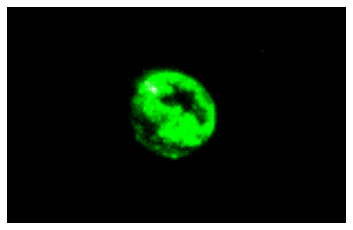

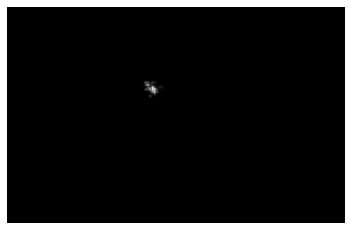

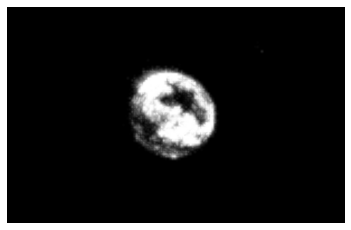

In [12]:
movie_3d(stack=crop, channels_list=['Confocal 561 2', 'Confocal 488'], vis_params=vis_params,
         script='movies/3b_movie_script.txt', movie_name='3b_movie')

### Read movies

In [41]:
max_projections = {'merge':skvideo.io.vread('movies/3b_movie_merge.mp4'),
                  'sac6':skvideo.io.vread('movies/3b_movie_Sac6-RFP.mp4'),
                  'bzz1':skvideo.io.vread('movies/3b_movie_Bzz1-GFP.mp4')}
max_projections['merge'].shape

(52, 960, 1500, 3)

### Make montage figure panel from movies
I need to fix this to take the metadata dataframe info instead

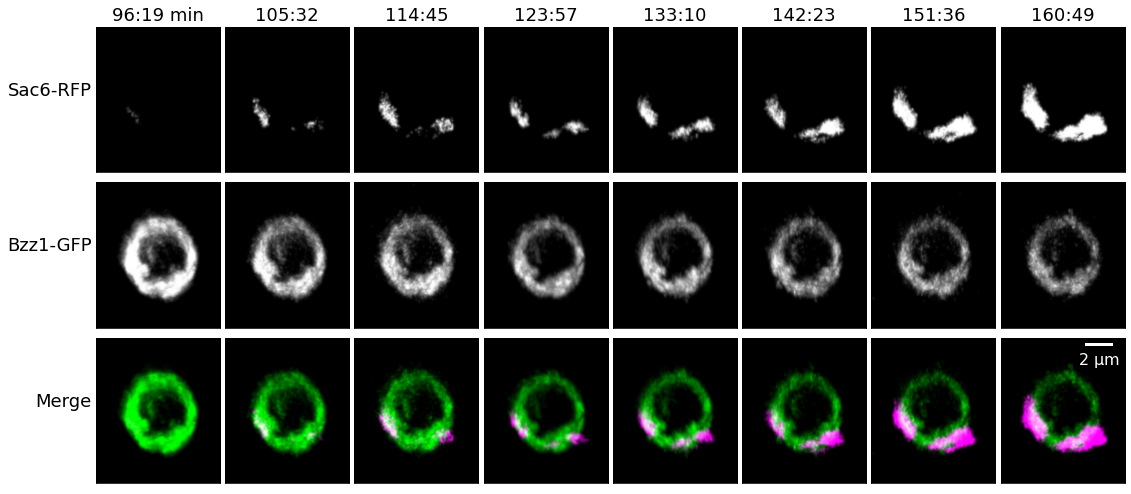

In [44]:
all_frames = range(crop.shape[0])
frames = all_frames[1::7]
count = 0
width = 2*len(frames)
height = 0.45 * width
channels = ['sac6','bzz1','merge']
plt.figure(figsize=(width,height))

for channel in channels:
    for tp in frames:
        count += 1
        plt.subplot(len(channels),len(frames),count)
        plt.imshow(max_projections[channel][tp,120:880,400:1050])
        #plt.axis('off')
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        if channel == 'sac6':
            minutes = int(s_per_frame*tp//60)
            seconds = int(np.round((s_per_frame*tp/60-minutes)*60))
            if tp == frames[0]:
                plt.title(str(95+minutes)+':'+str(seconds)+' min')
            else:
                plt.title(str(95+minutes)+':'+str(seconds))
        if tp == frames[0]:
            plt.ylabel(labels[channel],rotation=0,
                       ha='right',)
        if count == len(frames)*len(channels):
            scalebar = ScaleBar(micron_per_px/10, 'um', box_alpha=0, color='w', 
                                length_fraction=0.4, height_fraction=0.02)
            plt.gca().add_artist(scalebar)

plt.tight_layout(h_pad=0.2,w_pad=0.1)

plt.savefig('figures/3b_montage_draft.svg')
plt.savefig('figures/3b_montage_draft.png')

## Make time lapse movie with 3D rotations

### Write movie script

rotation is around x-axis (upward), around z in-plane (clockwise), around y-axis (leftward)

In [48]:
tl_frames = crop.shape[0]-1
rotation_frames = 50
with open("movies/3b_rotation_movie_script.txt", "w") as text_file:
    print('From frame 0 to frame 0\n'
    '-rotate by 310 degrees around (1,0,0)\n'
    '-rotate by 40 degrees around (0,1,0)\n'
    f'From frame 0 to frame {rotation_frames}\n'
    '-rotate by 360 degrees around (0,1,0)\n'
    f'From frame {rotation_frames} to frame {rotation_frames+tl_frames}\n'
    f'-shift time by {tl_frames}\n'
    f'From frame {rotation_frames+tl_frames} to frame {2*rotation_frames+tl_frames}\n'
    '-rotate by 360 degrees around (0,1,0)', file=text_file)

### Record movie in napari

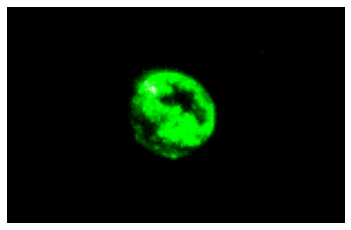

In [44]:
viewer = napari.Viewer(ndisplay=3)

for i, channel in enumerate(['sac6','bzz1']):
    crop_channel = crop[...,i]
    
    viewer.add_image(crop_channel, colormap=colors[channel],
                 name=channel, scale=[1,z_spacing,micron_per_px,micron_per_px],
                 contrast_limits=contrast[channel], blending='additive')
    
movie = Movie(myviewer=viewer)
movie.create_state_dict_from_script('movies/3b_rotation_movie_script.txt')
movie.make_movie(name = 'movies/3b_rotation_movie_merge.mp4', resolution = 320, fps = 20)

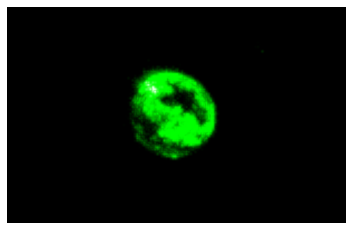

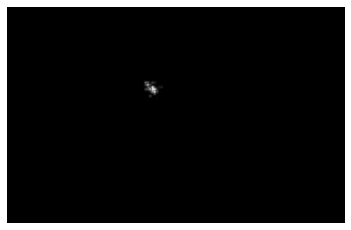

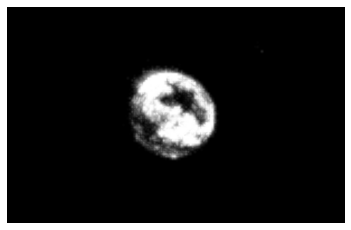

In [13]:
movie_3d(stack=crop, channels_list=['Confocal 561 2', 'Confocal 488'], vis_params=vis_params,
         script='movies/3b_rotation_movie_script.txt', movie_name='3b_rotation_movie')

### Read movie

In [13]:
rotation_movie = skvideo.io.vread('movies/3b_rotation_movie_merge.mp4')
rotation_movie.shape

(152, 960, 1504, 3)

### make timepoints to label movie

In [14]:
frames = range(crop.shape[0])
frame_labels = np.concatenate((np.zeros(rotation_frames),
                              np.array(frames),
                              np.full(rotation_frames,frames[-1])))
time_labels = frame_labels*s_per_frame/60+95

NameError: name 'rotation_frames' is not defined

### label movie with timepoints and scale bar, save as tiffs

/opt/miniconda3/envs/image_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


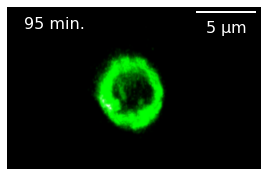

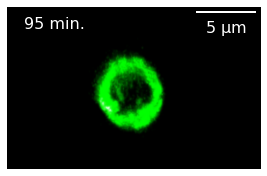

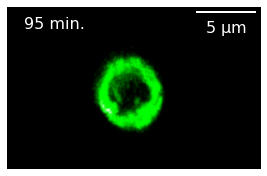

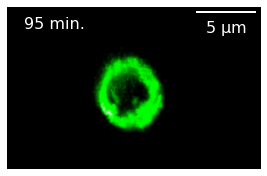

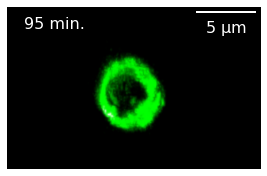

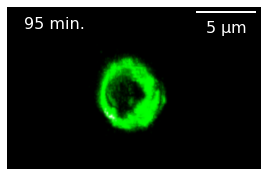

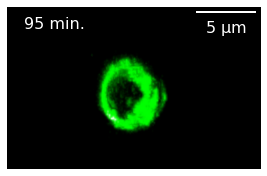

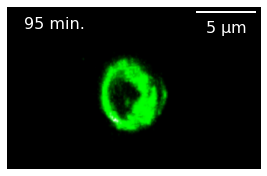

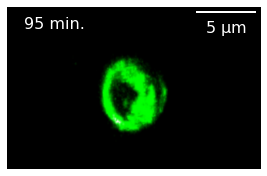

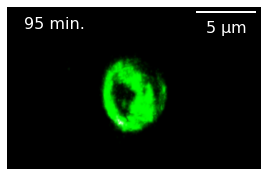

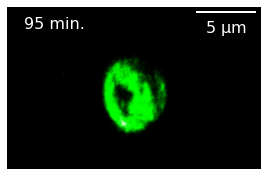

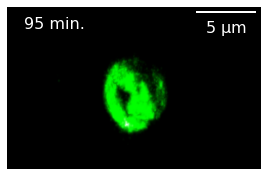

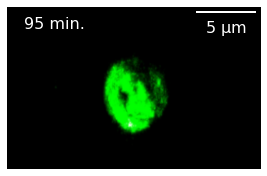

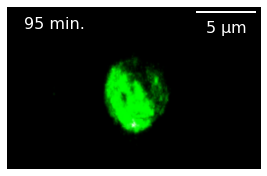

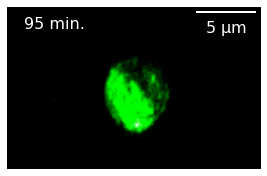

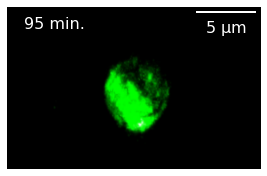

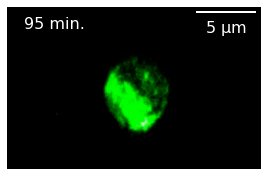

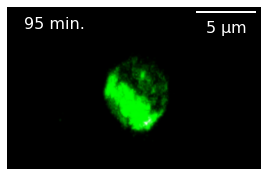

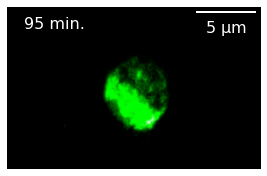

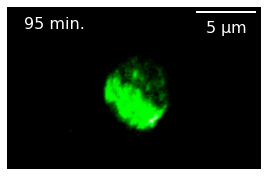

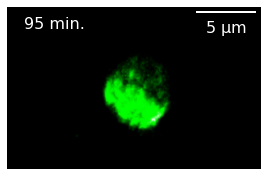

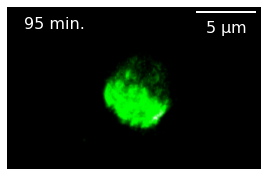

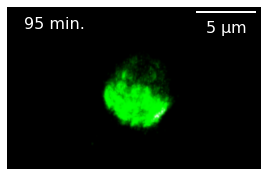

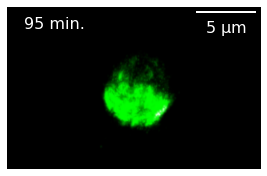

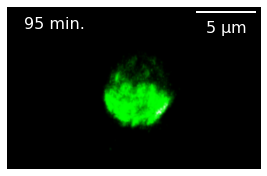

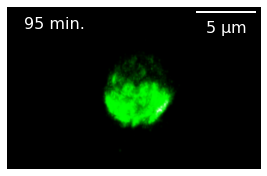

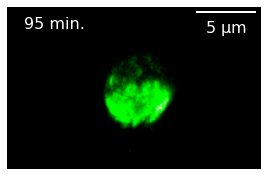

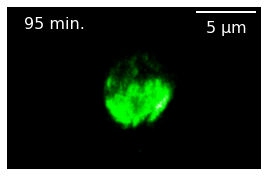

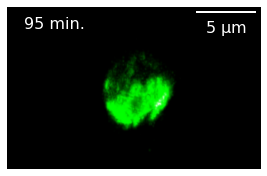

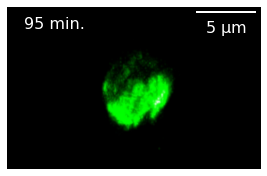

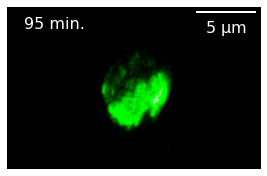

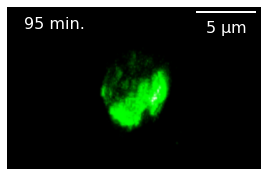

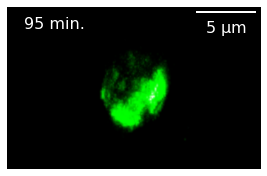

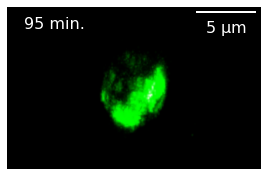

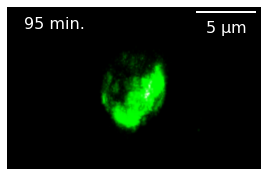

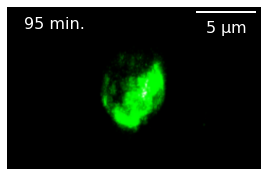

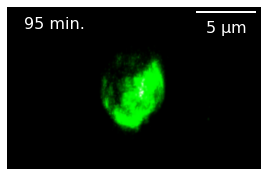

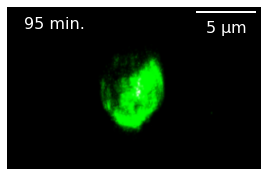

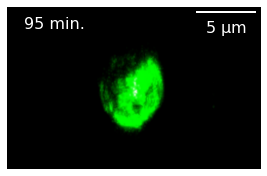

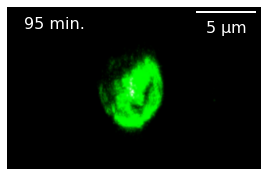

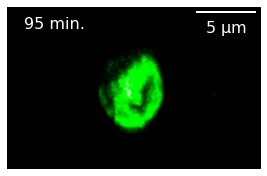

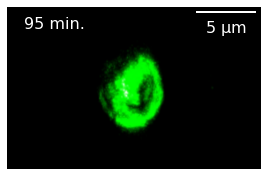

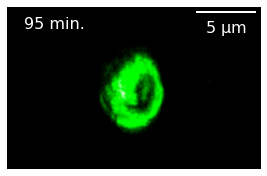

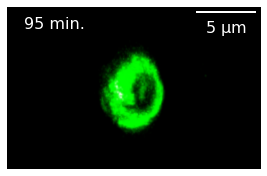

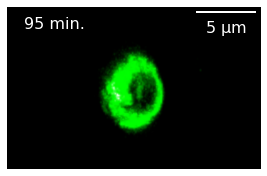

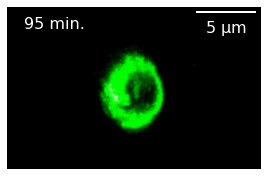

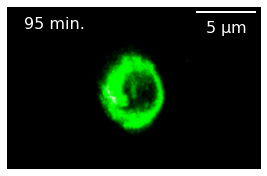

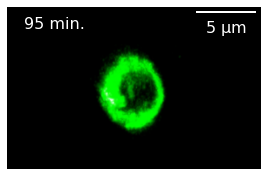

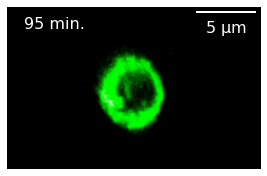

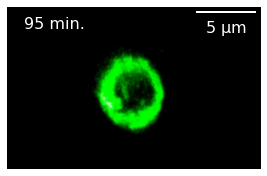

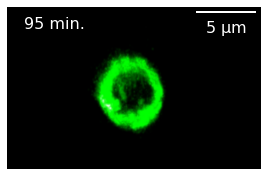

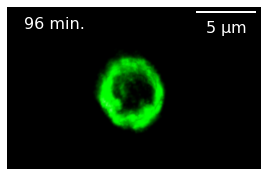

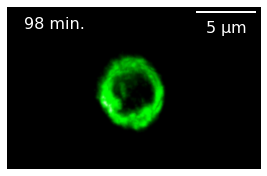

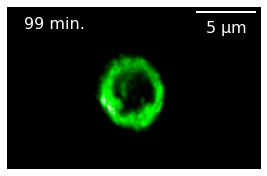

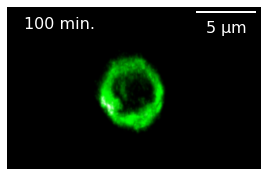

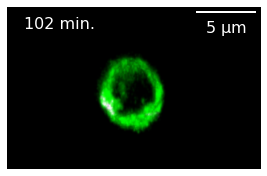

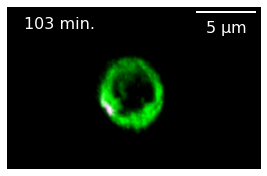

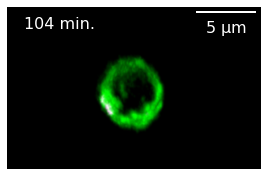

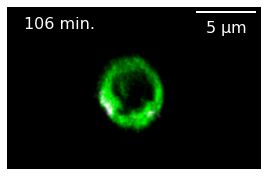

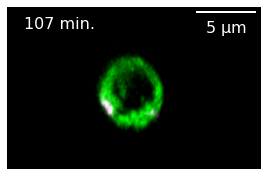

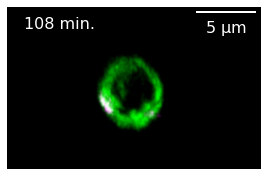

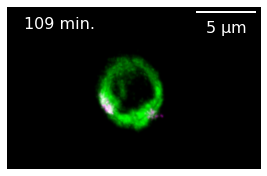

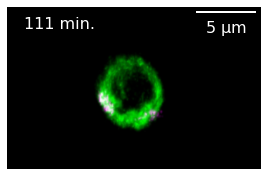

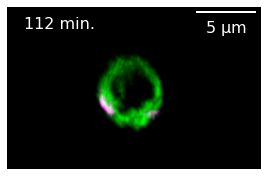

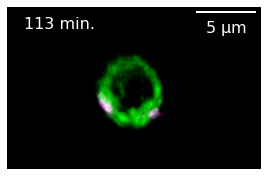

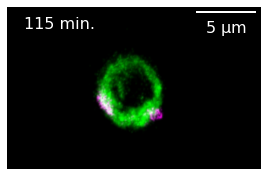

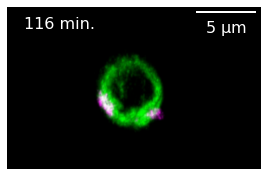

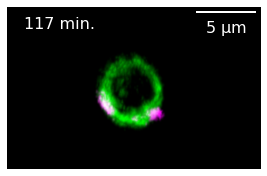

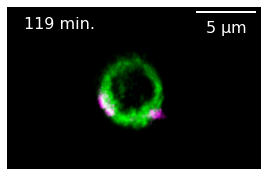

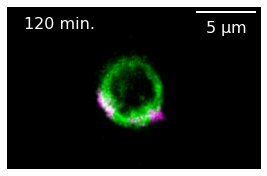

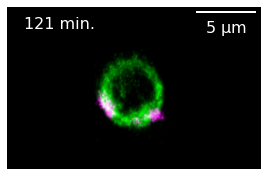

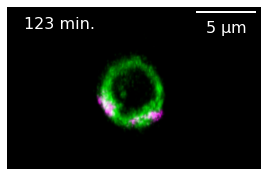

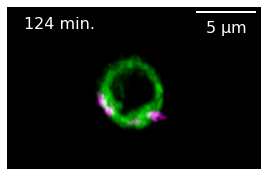

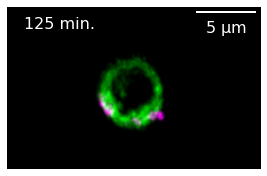

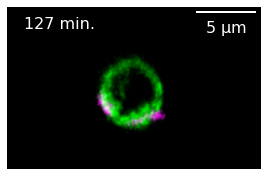

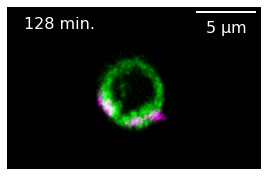

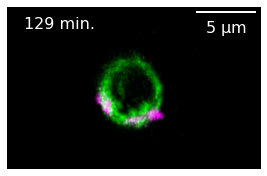

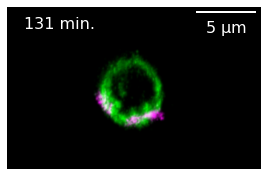

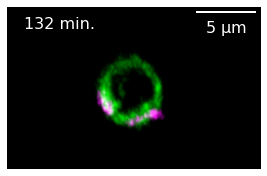

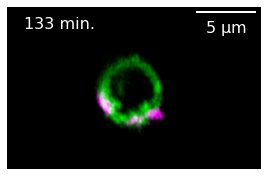

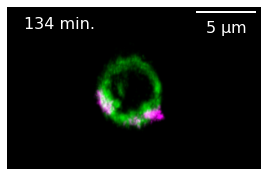

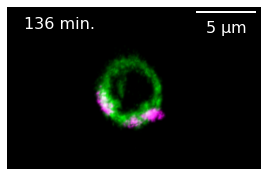

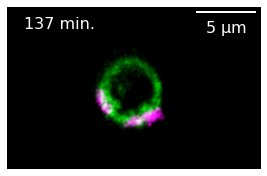

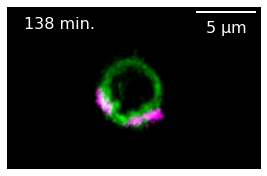

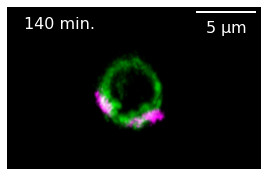

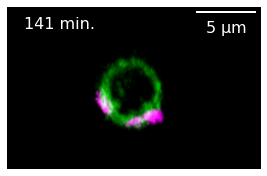

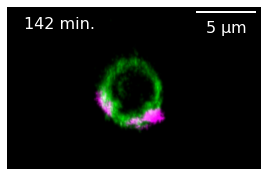

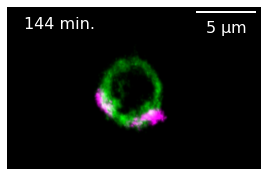

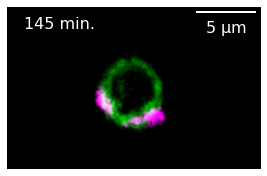

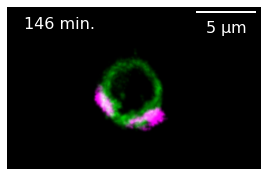

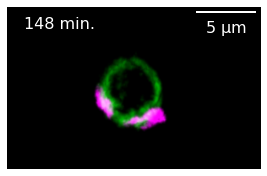

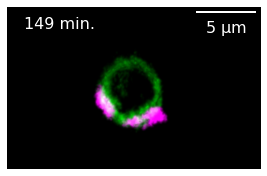

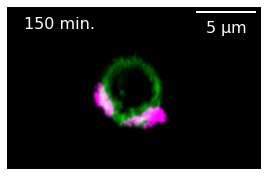

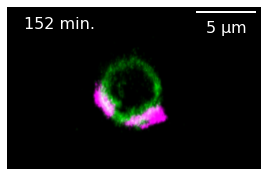

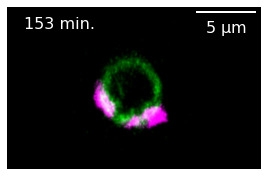

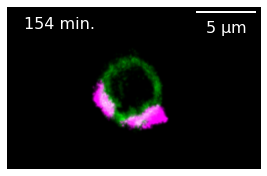

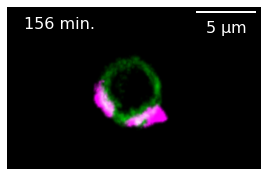

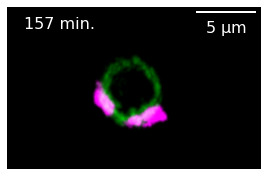

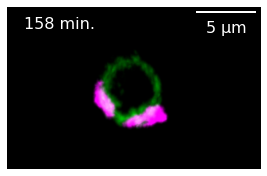

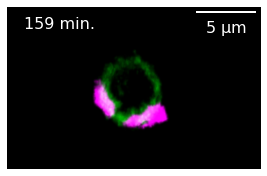

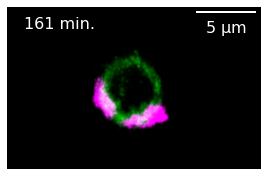

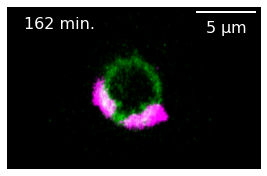

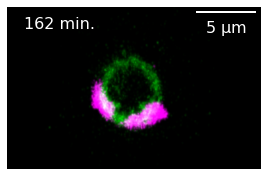

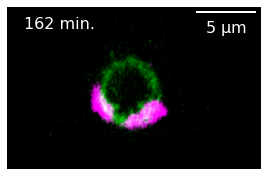

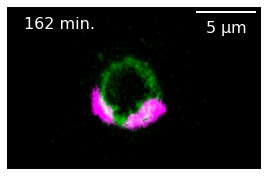

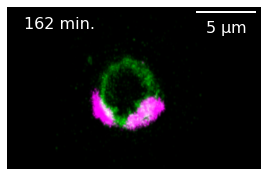

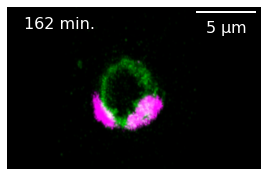

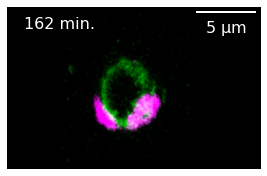

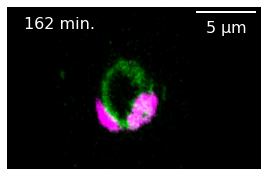

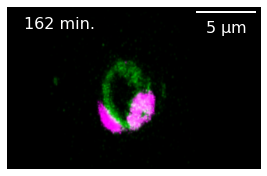

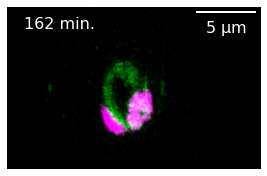

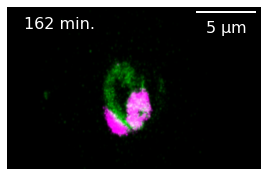

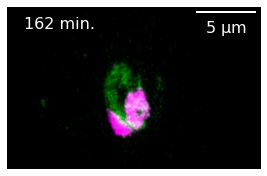

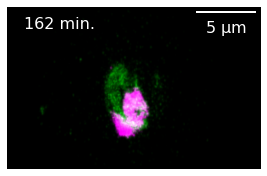

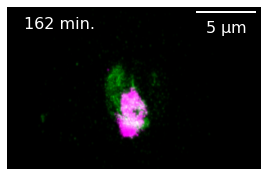

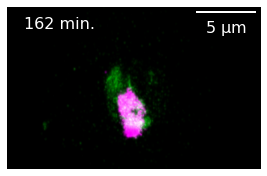

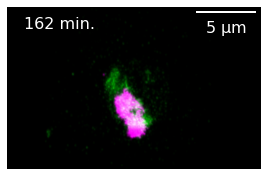

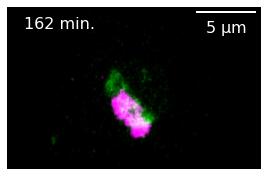

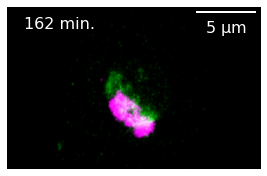

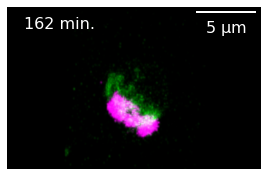

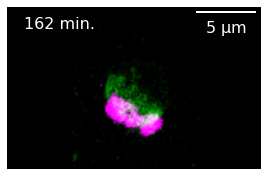

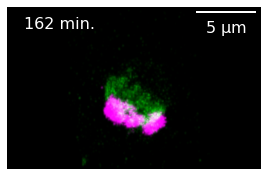

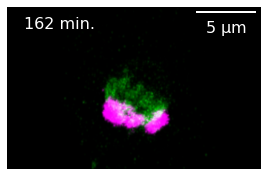

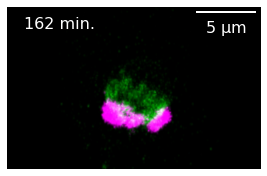

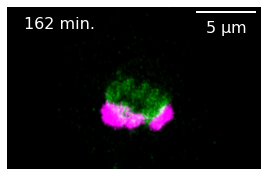

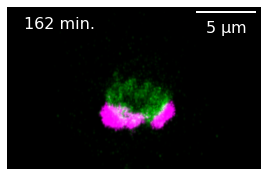

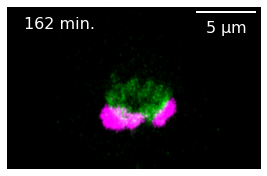

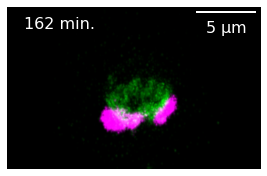

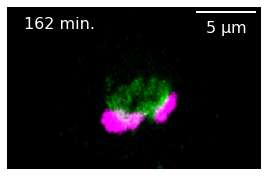

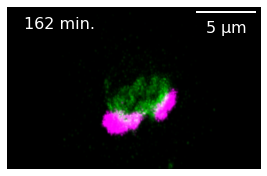

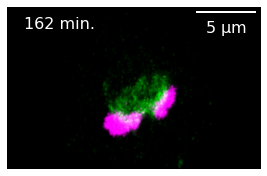

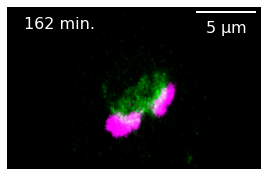

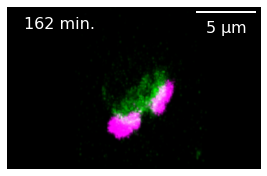

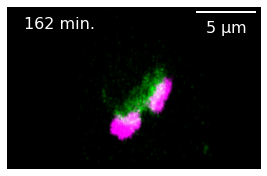

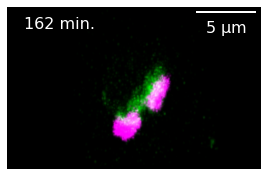

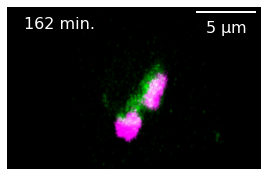

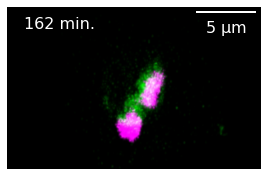

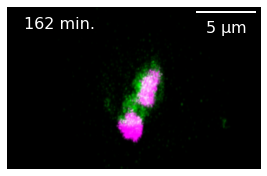

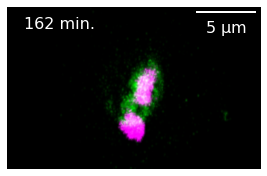

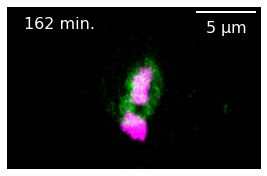

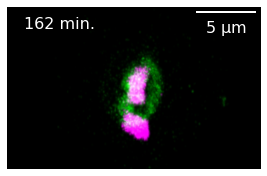

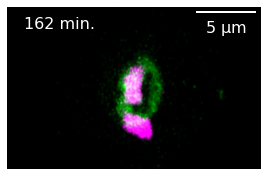

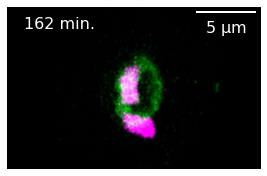

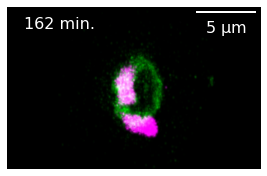

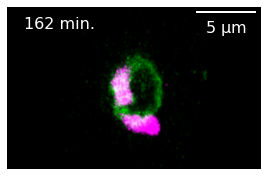

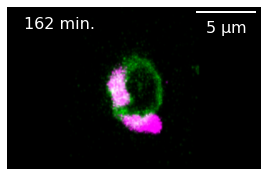

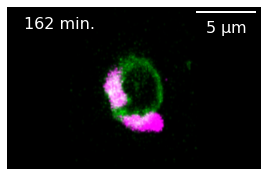

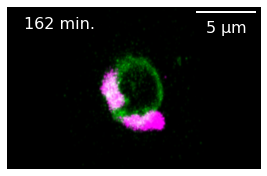

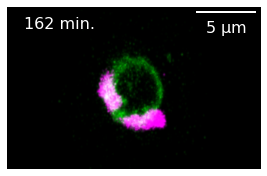

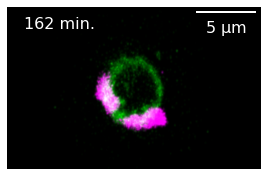

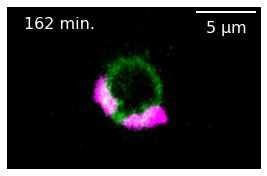

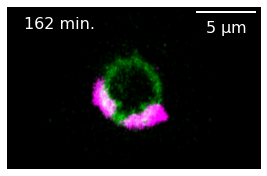

In [47]:
for frame in range(rotation_movie.shape[0]):
    plt.figure(figsize=(4,3))
    plt.imshow(rotation_movie[frame,...])
    plt.axis('off')
    plt.text(100,100,str(int(round(time_labels[frame])))+' min.', color='w', 
         horizontalalignment='left', verticalalignment='center')
    scalebar = ScaleBar(micron_per_px/10, 'um', box_alpha=0, color='w',
                length_fraction=0.4)
    plt.gca().add_artist(scalebar)
    plt.tight_layout()
    
    plt.savefig('figures/rotation_movie_allframes/'+str(frame)+'.tif')

### Encode tiffs to new video

In [48]:
stack = imread("figures/rotation_movie_allframes/*.tif")
skvideo.io.vwrite('movies/3b_rotation_movie_merge_labeled.avi', np.array(stack))
skvideo.io.vwrite('movies/3b_rotation_movie_merge_labeled.mov', np.array(stack))
skvideo.io.vwrite('movies/3b_rotation_movie_merge_labeled.mp4', np.array(stack))

# Image processing for figure 5a

## Set paths to data

In [62]:
crop_tiff = 'data/4.4.3M1001_bs_bcexp_bead1_dc.tif'
raw_nd2 = 'data/4.4.3M1001.nd2'
track_csv = 'tracks/4.4.3M1001_bs_bcexp_bead1_dc_trackmate.csv'

## Read processed single bead crop

In [63]:
crop = io.imread(crop_tiff)
crop.shape

(22, 23, 85, 76, 3)

## Read raw data corresponding to processed stack

In [64]:
raw = ND2Reader(raw_nd2)
raw.bundle_axes = 'czyx'
raw

<FramesSequenceND>
Axes: 5
Axis 'x' size: 512
Axis 'y' size: 512
Axis 'c' size: 3
Axis 't' size: 22
Axis 'z' size: 21
Pixel Datatype: <class 'numpy.float64'>

## Read metadata from raw data

In [66]:
s_per_frame = raw.metadata['experiment']['loops'][0]['sampling_interval']/1000
s_total = raw.timesteps[-1]/1000
micron_per_px = raw.metadata['pixel_microns']
min_z = np.min(raw.metadata['z_coordinates'])
max_z = np.max(raw.metadata['z_coordinates'])
z_range = max_z - min_z
z_slices = np.max(raw.metadata['z_levels'])+1
z_spacing = z_range/z_slices
px_per_micron = 1/micron_per_px
xy_scale = micron_per_px*px_per_micron
z_scale = z_spacing*px_per_micron

#correct scaling from trackmate in fiji
trackmate_z_spacing = 0.5
trackmate_micron_per_px = 0.1405

trackmate_z_ratio = z_spacing/trackmate_z_spacing
trackmate_xy_ratio = micron_per_px/trackmate_micron_per_px

In [67]:
raw_metadata = nd2_metadata(raw)

## Read vesicle tracking data

In [68]:
track_df = pd.read_csv(track_csv)
frames = track_df['FRAME']
x = track_df['POSITION_X']*trackmate_xy_ratio*px_per_micron
y = track_df['POSITION_Y']*trackmate_xy_ratio*px_per_micron
z = track_df['POSITION_Z']*trackmate_z_ratio*px_per_micron
spots = np.transpose(np.array([frames,z,y,x]))
traj = np.transpose(np.array([z,y,x]))

## Set visualization parameters

In [69]:
contrast = {'sac6':(575,2345),
            'bzz1':(170,310),
            'dope':(400,745)}
colors = {'sac6':'magenta',
        'bzz1':'green',
        'dope':'cyan'}
labels = {'sac6':'Sac6-RFP',
        'bzz1':'Bzz1-GFP',
        'dope':'ATTO647-DOPE',
         'merge':'Merge'}
z_low, z_high = 9,13
y_low, y_high = 0,40
x_low, x_high = 18,56

## Manually set visualization parameters, combine with metadata

In [70]:
channel_names = {'sac6':'Confocal 561 2',
                'bzz1':'Confocal 488',
                'dope':'Confocal 638'}
contrast = {'sac6':(575,2345),
            'bzz1':(170,310),
            'dope':(400,745)}
colors = {'sac6':'magenta',
        'bzz1':'green',
        'dope':'cyan'}
#labels = {'sac6':'Sac6-RFP',
#        'bzz1':'Bzz1-GFP',
#        'dope':'ATTO647-DOPE',
#         'merge':'Merge'}
labels = {'sac6':'Sac6-RFP',
        'bzz1':'Bzz1-GFP',
        'dope':'ATTO647-DOPE'}

vis_params = pd.DataFrame({'channel':channel_names,
             'contrast':contrast,
             'color':colors,
             'label':labels}).set_index('channel')
channel_order = {'stack_index':{}}
for i, channel in enumerate(raw_metadata['channel']):
    channel_order['stack_index'][channel] = i

vis_params = pd.concat([vis_params,pd.DataFrame(channel_order),
                       pd.DataFrame(raw_metadata).set_index('channel')],axis=1)

# hack to add merge visualization
vpm = vis_params.loc[vis_params.index[0]].copy()
vpm['label'] = 'Merge'
vpm['color'] = 'black'
vis_params.loc['Merge'] = vpm

#vis_params.loc['Merge'] = vis_params.loc[vis_params.index[0]].copy()
#vis_params.loc['Merge']['color'] = 'black'
#vis_params.loc['Merge']['label'] = 'Merge'
vis_params

contrast    color         label  stack_index  num_frames  \
Confocal 561 2  (575, 2345)  magenta      Sac6-RFP            0          22   
Confocal 488     (170, 310)    green      Bzz1-GFP            1          22   
Confocal 638     (400, 745)     cyan  ATTO647-DOPE            2          22   
Merge           (575, 2345)    black         Merge            0          22   

                s_per_frame      s_total  micron_per_px   min_z    max_z  \
Confocal 561 2    57.433345  1262.641326       0.140467  2146.9  2156.55   
Confocal 488      57.433345  1262.641326       0.140467  2146.9  2156.55   
Confocal 638      57.433345  1262.641326       0.140467  2146.9  2156.55   
Merge             57.433345  1262.641326       0.140467  2146.9  2156.55   

                z_range  z_slices  z_spacing  trackmate_z_ratio  \
Confocal 561 2     9.65        21   0.459524           0.919048   
Confocal 488       9.65        21   0.459524           0.919048   
Confocal 638       9.65        21   0.459524           0.919048   
Merge              9.65        21   0.459524           0.919048   

                trackmate_xy_ratio  
Confocal 561 2            0.999763  
Confocal 488              0.999763  
Confocal 638              0.999763  
Merge                     0.999763

## Make movies/montages

### full time lapse

#### write movie script

In [262]:
tl_frames = crop.shape[0]-1
with open("movies/5a_movie_script.txt", "w") as text_file:
    print(
f'From frame 0 to frame {tl_frames} shift time by {tl_frames}', 
        file=text_file)

#### Record movies in napari

##### merge of sac6, bzz1, and lipid

/opt/miniconda3/envs/image_analysis/lib/python3.7/site-packages/napari/layers/utils/color_transformations.py:52: UserWarning: The provided edge_color parameter has 22 entries, while the data contains 1 entries. Setting edge_color to white.
  f"The provided {elem_name} parameter has {len(colors)} entries, "
/opt/miniconda3/envs/image_analysis/lib/python3.7/site-packages/napari/layers/utils/color_transformations.py:52: UserWarning: The provided face_color parameter has 22 entries, while the data contains 1 entries. Setting face_color to white.
  f"The provided {elem_name} parameter has {len(colors)} entries, "


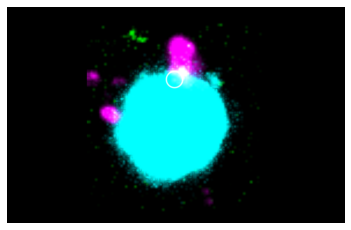

In [266]:
viewer = napari.Viewer(ndisplay=3)

for i, channel in enumerate(['sac6','bzz1','dope']):
    crop_channel = crop[...,i]
    
    viewer.add_image(crop_channel, colormap=colors[channel],
                 name=channel, scale=[1,z_scale,xy_scale,xy_scale],
                 contrast_limits=contrast[channel], blending='additive')
    
viewer.add_points(spots, face_color='#ffffff00', edge_color='white', 
                  size=5, edge_width=3, opacity=0.7,
                  symbol='disc', name='vesicle')
viewer.add_shapes(traj, shape_type='path', edge_color='red', name='track', 
                  edge_width=0.5, visible=False)

movie = Movie(myviewer=viewer)
movie.create_state_dict_from_script('movies/5a_movie_script.txt')
movie.make_movie(name = 'movies/5a_movie_merge.mp4', resolution = 320, fps = 20)

##### each channel separately

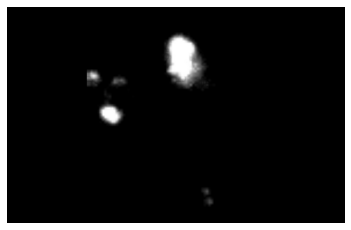

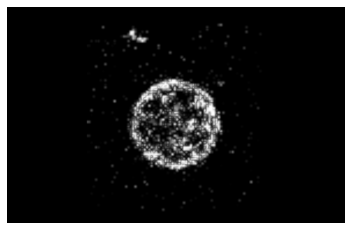

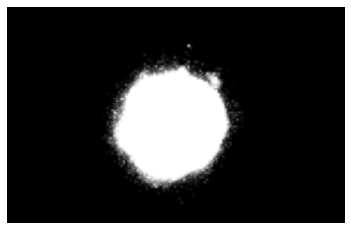

In [267]:
for i, channel in enumerate(['sac6','bzz1','dope']):
    viewer = napari.Viewer(ndisplay=3)
    crop_channel = crop[...,i]
    
    viewer.add_image(crop_channel, colormap='gray',
                 name=channel, scale=[1,z_scale,xy_scale,xy_scale],
                 contrast_limits=contrast[channel], blending='additive')
    
    movie = Movie(myviewer=viewer)
    movie.create_state_dict_from_script('movies/5a_movie_script.txt')
    movie.make_movie(name = 'movies/5a_movie_'+channel+'_gray.mp4', resolution = 320, fps = 20)

### Narrower z-section time lapse

#### Record movies in napari

##### merge of sac6, bzz1, and lipid

In [72]:
viewer = napari.Viewer(ndisplay=3)

for i, channel in enumerate(['sac6','bzz1','dope']):
    crop_channel = crop[...,i]
    crop_slice = np.zeros_like(crop_channel)
    crop_slice[:,z_low:z_high,...] = crop_channel[:,z_low:z_high,...]

    viewer.add_image(crop_slice, colormap=colors[channel],
                 name=channel, scale=[1,z_scale,xy_scale,xy_scale],
                 contrast_limits=contrast[channel], blending='additive')
    
viewer.add_points(spots, face_color='#ffffff00', edge_color='white', 
                  size=5, edge_width=3, opacity=0.7,
                  symbol='disc', name='vesicle')
viewer.add_shapes(traj, shape_type='path', edge_color='red', name='track', 
                  edge_width=0.5, visible=False)

movie = Movie(myviewer=viewer)
movie.create_state_dict_from_script('movies/5a_movie_script.txt')
movie.make_movie(name = 'movies/5a_movie_slice_merge.mp4', resolution = 320, fps = 20)

<Shapes layer 'track' at 0x7fc5d0180e50>

##### each channel separately

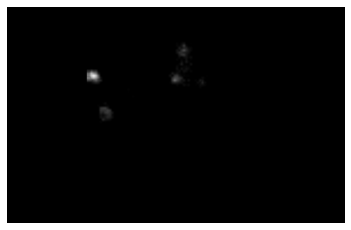

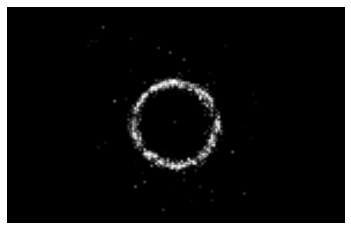

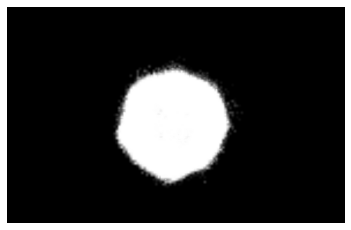

In [60]:
for i, channel in enumerate(['sac6','bzz1','dope']):
    viewer = napari.Viewer(ndisplay=3)
    crop_channel = crop[...,i]
    crop_slice = np.zeros_like(crop_channel)
    crop_slice[:,z_low:z_high,...] = crop_channel[:,z_low:z_high,...]

    viewer.add_image(crop_slice, colormap='gray',
                 name=channel, scale=[1,z_scale,xy_scale,xy_scale],
                 contrast_limits=contrast[channel], blending='additive')
    
    movie = Movie(myviewer=viewer)
    movie.create_state_dict_from_script('movies/5a_movie_script.txt')
    movie.make_movie(name = 'movies/5a_movie_slice_'+channel+'_gray.mp4', resolution = 320, fps = 20)

#### Read movies

In [26]:
max_projections = {'Merge':skvideo.io.vread('movies/5a_movie_slice_merge.mp4'),
                  'Confocal 561 2':skvideo.io.vread('movies/5a_movie_slice_sac6_gray.mp4'),
                  'Confocal 488':skvideo.io.vread('movies/5a_movie_slice_bzz1_gray.mp4'),
                  'Confocal 638':skvideo.io.vread('movies/5a_movie_slice_dope_gray.mp4')}
max_projections['Merge'].shape

(22, 960, 1500, 3)

#### Make montage figure panel from movies

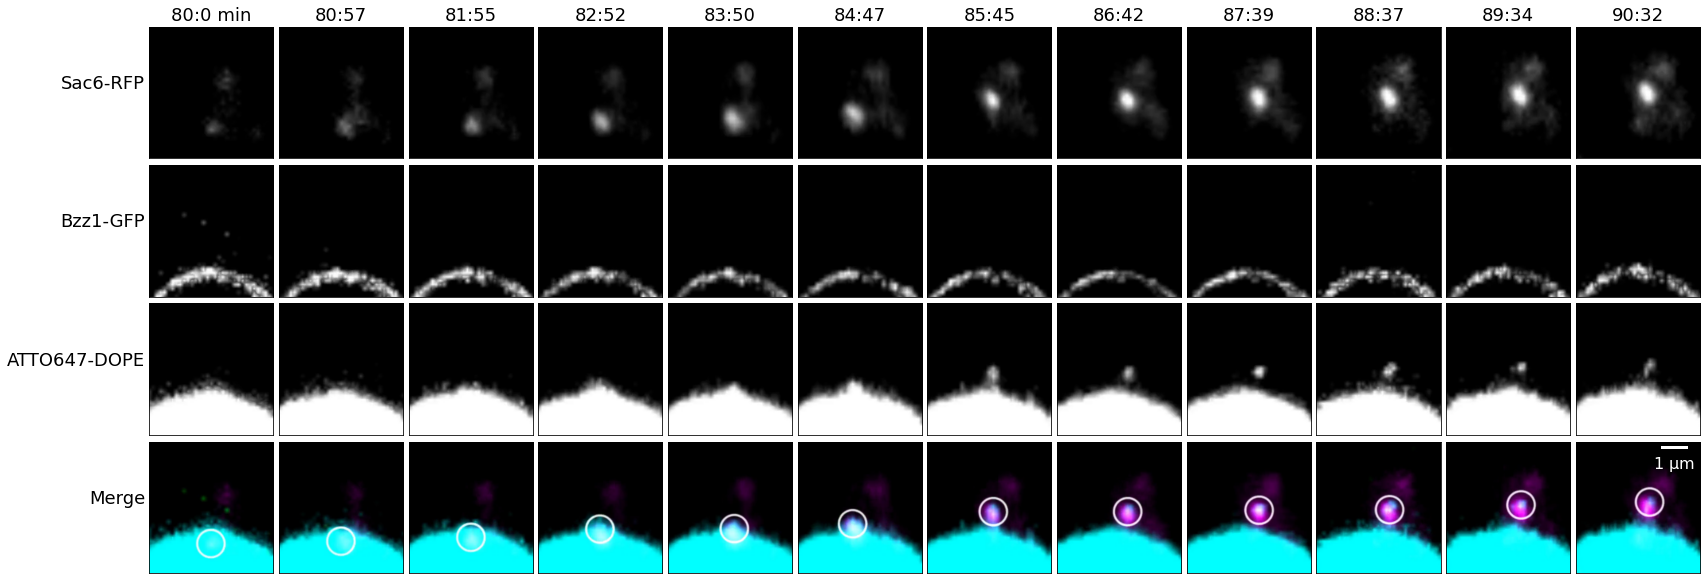

In [271]:
all_frames = range(crop.shape[0])
frames = all_frames[0:12]
count = 0
width = 2*len(frames)
height = 0.35 * width
channels = ['sac6','bzz1','dope','merge']
plt.figure(figsize=(width,height))

for channel in channels:
    for tp in frames:
        count += 1
        plt.subplot(len(channels),len(frames),count)
        plt.imshow(max_projections[channel][tp,50:400,580:910])
        #plt.axis('off')
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        if channel == 'sac6':
            minutes = int(s_per_frame*tp//60)
            seconds = int(np.round((s_per_frame*tp/60-minutes)*60))
            if tp == frames[0]:
                plt.title(str(80+minutes)+':'+str(seconds)+' min')
            else:
                plt.title(str(80+minutes)+':'+str(seconds))
        if tp == frames[0]:
            plt.ylabel(labels[channel],rotation=0,
                       ha='right',)
        if count == len(frames)*len(channels):
            scalebar = ScaleBar(micron_per_px/10, 'um', box_alpha=0, color='w', 
                                length_fraction=0.4, height_fraction=0.02)
            plt.gca().add_artist(scalebar)

plt.tight_layout(h_pad=0.2,w_pad=0.1)

plt.savefig('figures/5a_montage_draft.svg')
plt.savefig('figures/5a_montage_draft.png')

### Narrower z-section time lapse with 3D rotation

#### write movie script

In [272]:
tl_frames = crop.shape[0]-1
tl_delay = tl_frames*3
rotation_frames = 50
with open("movies/5a_rotation_movie_script.txt", "w") as text_file:
    print(
'At frame 0 make layer 4 invisible\n'
f'From frame 0 to frame {rotation_frames} rotate by 360 degrees around (0,0,1)\n'
f'From frame {rotation_frames} to frame {rotation_frames+tl_delay} shift time by {tl_frames}\n'
f'At frame {rotation_frames+tl_delay} make layer 4 visible\n'
f'From frame {rotation_frames+tl_delay} to frame {rotation_frames+tl_delay*2} shift time by -{tl_frames}\n'
f'From frame {rotation_frames+tl_delay*2} to frame {rotation_frames*2+tl_delay*2} rotate by 360 degrees around (0,0,1)\n'
f'From frame {rotation_frames*2+tl_delay*2} to frame {rotation_frames*2+tl_delay*3} shift time by {tl_frames}', 
        file=text_file)

#### Record movies in napari

##### merge of sac6, bzz1, and lipid

/opt/miniconda3/envs/image_analysis/lib/python3.7/site-packages/napari/layers/utils/color_transformations.py:52: UserWarning: The provided edge_color parameter has 22 entries, while the data contains 1 entries. Setting edge_color to white.
  f"The provided {elem_name} parameter has {len(colors)} entries, "
/opt/miniconda3/envs/image_analysis/lib/python3.7/site-packages/napari/layers/utils/color_transformations.py:52: UserWarning: The provided face_color parameter has 22 entries, while the data contains 1 entries. Setting face_color to white.
  f"The provided {elem_name} parameter has {len(colors)} entries, "


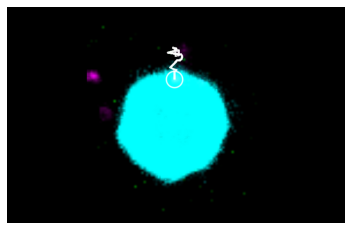

In [273]:
viewer = napari.Viewer(ndisplay=3)

for i, channel in enumerate(['sac6','bzz1','dope']):
    crop_channel = crop[...,i]
    crop_slice = np.zeros_like(crop_channel)
    crop_slice[:,z_low:z_high,...] = crop_channel[:,z_low:z_high,...]

    viewer.add_image(crop_slice, colormap=colors[channel],
                 name=channel, scale=[1,z_scale,xy_scale,xy_scale],
                 contrast_limits=contrast[channel], blending='additive')
    
viewer.add_points(spots, face_color='#ffffff00', edge_color='white', 
                  size=5, edge_width=3, opacity=0.7,
                  symbol='disc', name='vesicle')
viewer.add_shapes(traj, shape_type='path', edge_color='red', name='track', edge_width=0.5)

movie = Movie(myviewer=viewer)
movie.create_state_dict_from_script('movies/5a_rotation_movie_script.txt')
movie.make_movie(name = 'movies/5a_rotation_movie_slice_merge.mp4', resolution = 320, fps = 20)

# Vesicle track analysis for figure 5b-c

## Make list of vesicle tracks

In [14]:
tracks_filenames = []

for f in os.listdir('tracks/'):
    if f.endswith('.csv'):
        tracks_filenames.append(f)
        
tracks_filenames

['4.4.2B1.2_bs_bcexp_bead1_dc_trackmate.csv',
 '4.4.4M1002_bs_bcexp_bead2_dc_trackmate.csv',
 '4.4.4M1003_bs_bcexp_bead1_dc_trackmate.csv',
 '4.4.4M1001_bs_bcexp_bead1_dc_trackmate.csv',
 '4.4.4M1001_bs_bcexp_bead2_dc_trackmate.csv',
 '4.4.4M1001_bs_bcexp_bead4_dc_trackmate.csv',
 '4.4.4M1001_bs_bcexp_bead5_dc_trackmate.csv',
 '4.4.4M2003_bs_bcexp_bead1_dc_trackmate.csv',
 '4.4.3M1001_bs_bcexp_bead1_dc_trackmate.csv',
 '4.4.4M1001_bs_bcexp_bead6_dc_trackmate.csv',
 '4.4.4M2003_bs_bcexp_bead3_dc_trackmate.csv',
 '4.4.4M2003_bs_bcexp_bead4_dc_trackmate.csv',
 '4.4.4M1002_bs_bcexp_bead1_dc_trackmate.csv',
 '4.4.4M2003_bs_bcexp_bead5_dc_trackmate.csv',
 '4.4.4M1002_bs_bcexp_bead4.1_dc_trackmate.csv',
 '4.4.4M1002_bs_bcexp_bead4.2_dc_trackmate.csv',
 '4.4.4M1002_bs_bcexp_bead6_dc_trackmate.csv',
 '4.4.4M1002_bs_bcexp_bead7_dc_trackmate.csv',
 '4.4.4M1002_bs_bcexp_bead8_dc_trackmate.csv',
 '4.4.5M1002_bs_bcexp_bead1_dc_trackmate.csv',
 '4.4.4M2003_bs_bcexp_bead7_dc_trackmate.csv']

## Read tracks into dataframes and organize in a dictionary

In [15]:
beads_dict = {}

for f in tracks_filenames:
    bead_df = pd.read_csv('tracks/'+f)
    beads_dict[f] = bead_df
    
list(beads_dict)

['4.4.2B1.2_bs_bcexp_bead1_dc_trackmate.csv',
 '4.4.4M1002_bs_bcexp_bead2_dc_trackmate.csv',
 '4.4.4M1003_bs_bcexp_bead1_dc_trackmate.csv',
 '4.4.4M1001_bs_bcexp_bead1_dc_trackmate.csv',
 '4.4.4M1001_bs_bcexp_bead2_dc_trackmate.csv',
 '4.4.4M1001_bs_bcexp_bead4_dc_trackmate.csv',
 '4.4.4M1001_bs_bcexp_bead5_dc_trackmate.csv',
 '4.4.4M2003_bs_bcexp_bead1_dc_trackmate.csv',
 '4.4.3M1001_bs_bcexp_bead1_dc_trackmate.csv',
 '4.4.4M1001_bs_bcexp_bead6_dc_trackmate.csv',
 '4.4.4M2003_bs_bcexp_bead3_dc_trackmate.csv',
 '4.4.4M2003_bs_bcexp_bead4_dc_trackmate.csv',
 '4.4.4M1002_bs_bcexp_bead1_dc_trackmate.csv',
 '4.4.4M2003_bs_bcexp_bead5_dc_trackmate.csv',
 '4.4.4M1002_bs_bcexp_bead4.1_dc_trackmate.csv',
 '4.4.4M1002_bs_bcexp_bead4.2_dc_trackmate.csv',
 '4.4.4M1002_bs_bcexp_bead6_dc_trackmate.csv',
 '4.4.4M1002_bs_bcexp_bead7_dc_trackmate.csv',
 '4.4.4M1002_bs_bcexp_bead8_dc_trackmate.csv',
 '4.4.5M1002_bs_bcexp_bead1_dc_trackmate.csv',
 '4.4.4M2003_bs_bcexp_bead7_dc_trackmate.csv']

## Separate out tracks from same bead

In [16]:
tracks_dict = {}

for d in beads_dict:
    track_ids = np.unique(beads_dict[d]['TRACK_ID'])
    for track in track_ids:
        track_name = d + '_track' + str(track)
        tracks_dict[track_name] = beads_dict[d][beads_dict[d]['TRACK_ID'] == track]
        
list(tracks_dict)

['4.4.2B1.2_bs_bcexp_bead1_dc_trackmate.csv_track1',
 '4.4.4M1002_bs_bcexp_bead2_dc_trackmate.csv_track0',
 '4.4.4M1003_bs_bcexp_bead1_dc_trackmate.csv_track0',
 '4.4.4M1001_bs_bcexp_bead1_dc_trackmate.csv_track0',
 '4.4.4M1001_bs_bcexp_bead2_dc_trackmate.csv_track0',
 '4.4.4M1001_bs_bcexp_bead4_dc_trackmate.csv_track0',
 '4.4.4M1001_bs_bcexp_bead4_dc_trackmate.csv_track2',
 '4.4.4M1001_bs_bcexp_bead5_dc_trackmate.csv_track0',
 '4.4.4M2003_bs_bcexp_bead1_dc_trackmate.csv_track0',
 '4.4.4M2003_bs_bcexp_bead1_dc_trackmate.csv_track1',
 '4.4.3M1001_bs_bcexp_bead1_dc_trackmate.csv_track0',
 '4.4.4M1001_bs_bcexp_bead6_dc_trackmate.csv_track0',
 '4.4.4M1001_bs_bcexp_bead6_dc_trackmate.csv_track1',
 '4.4.4M2003_bs_bcexp_bead3_dc_trackmate.csv_track0',
 '4.4.4M2003_bs_bcexp_bead4_dc_trackmate.csv_track0',
 '4.4.4M2003_bs_bcexp_bead4_dc_trackmate.csv_track1',
 '4.4.4M2003_bs_bcexp_bead4_dc_trackmate.csv_track2',
 '4.4.4M2003_bs_bcexp_bead4_dc_trackmate.csv_track3',
 '4.4.4M2003_bs_bcexp_bead4_d

## Calculate vesicle displacement by distance from initial position

In [17]:
for track in tracks_dict:
    df = tracks_dict[track]
    initial_x_0 = df[df['FRAME'] == 0]['POSITION_X']
    initial_y_0 = df[df['FRAME'] == 0]['POSITION_Y']
    initial_z_0 = df[df['FRAME'] == 0]['POSITION_Z']

    disp_x_0 = df['POSITION_X'] - float(initial_x_0)
    disp_y_0 = df['POSITION_Y'] - float(initial_y_0)
    disp_z_0 = df['POSITION_Z'] - float(initial_z_0)

    disp_3d_0 = np.sqrt(disp_x_0**2 + disp_y_0**2 + disp_z_0**2)

    df['DISPLACEMENT'] = disp_3d_0

/opt/miniconda3/envs/image_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


## Show how inflection points are calculated

slope=0.06413287586150627±0.0004380797481556241, intercept=-0.177813914379436±0.0038009006236234856, r=0.917104649893881, prob2=1.501483428349594e-06, see=0.007731755979199533
slope=0.006887384370415441±8.564062974346777e-06, intercept=-0.02502406577124533±0.00024398868452826247, r=0.5040448445197557, prob2=1.4144156285761904e-07, see=0.0012108070424120766
slope=0.1815120488233313±0.00029562679053014715, intercept=-0.6455772573366481±0.004150908354485169, r=0.9651870725136341, prob2=2.6696408877540384e-14, see=0.010487086353188414
slope=0.014317572239209025±1.3907718103460614e-05, intercept=-0.1511764848094004±0.0003879951265029397, r=0.6145523515237264, prob2=3.487785768425077e-11, see=0.0019058020507434184
slope=0.12595725938831484±7.824420168429516e-05, intercept=-0.1176278170981111±0.0013349196209139513, r=0.9886249775854228, prob2=9.390308247573365e-24, see=0.003687757180631105
slope=0.10084508495738059±0.00015203579747694634, intercept=0.16870135043679158±0.0024102216016451254, r

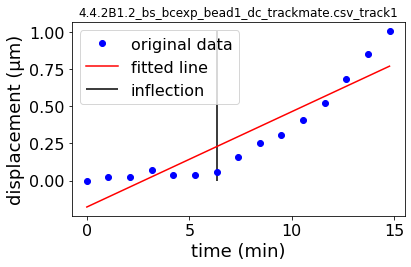

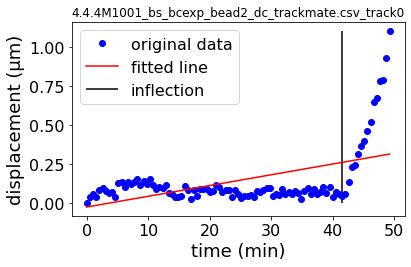

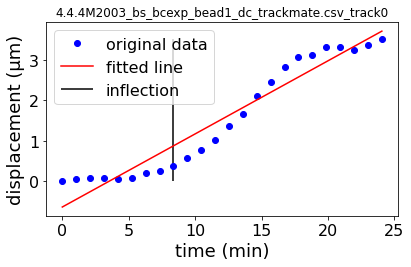

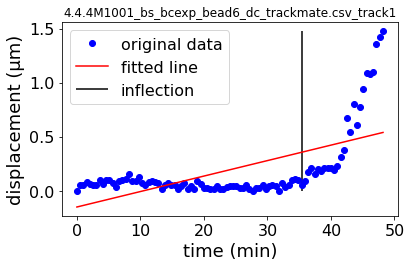

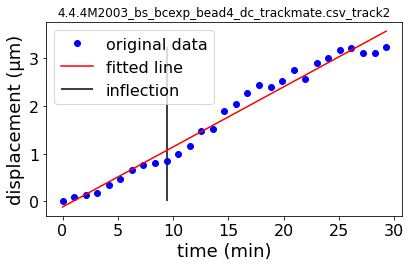

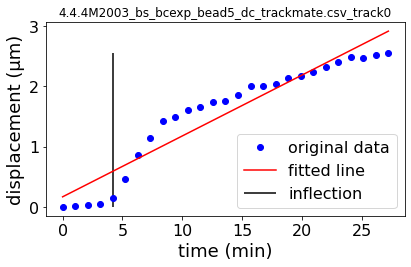

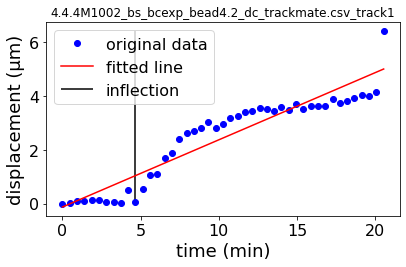

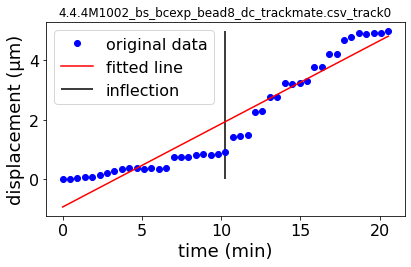

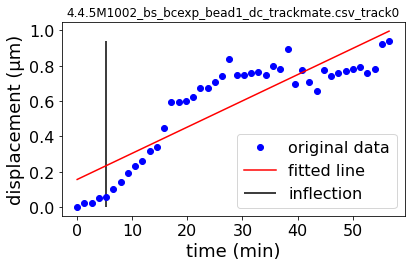

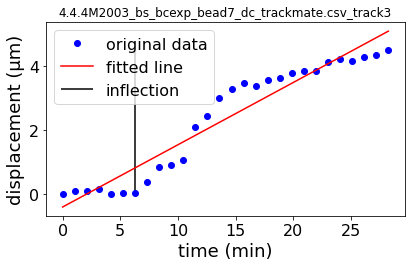

In [103]:
for track in list(tracks_dict)[::4]:
    df = tracks_dict[track].set_index('FRAME')
    time = df['POSITION_T']/60   
    ax = findInflectionPoint(time, df['DISPLACEMENT'],debug=True)
    plt.title(track, size=12)
    plt.tight_layout()
    plt.savefig('figures/findInflectionPoint_'+track+'.png')

## Plot fluorescence, displacement, and inflection point for all tracks

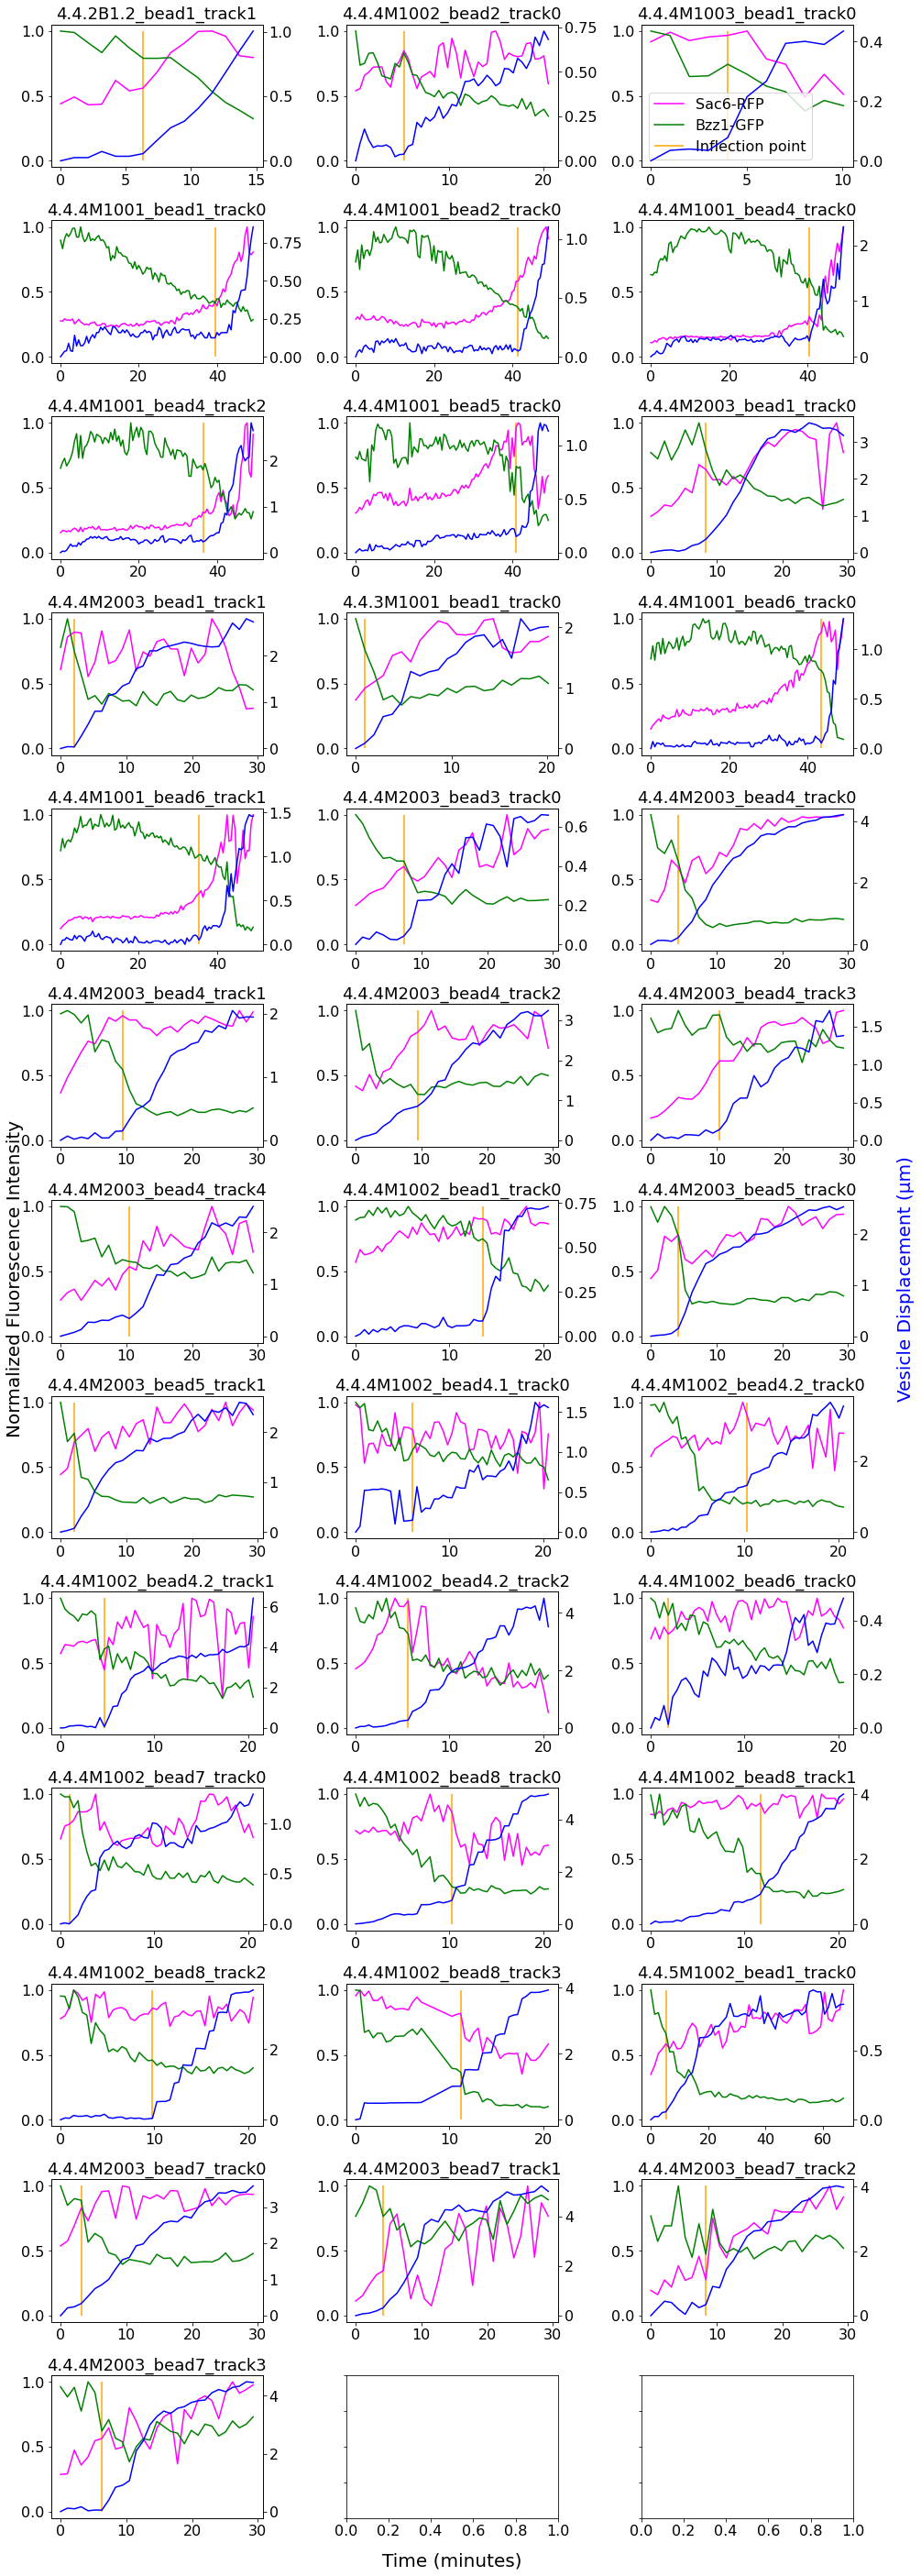

In [51]:
num_plots = len(tracks_dict)
width = 3
height = num_plots//width + 1

fig, ax = plt.subplots(nrows=height, ncols=width, sharex=True, sharey=True, figsize=(5*width,3*height))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
fig.text(0.5, 0, 'Time (minutes)', ha='center', size=20)
fig.text(0.05, 0.5, 'Normalized Fluorescence Intensity', va='center', rotation='vertical', size=20)
fig.text(0.95, 0.5, 'Vesicle Displacement (µm)', va='center', rotation='vertical', size=20, color='blue')

#plt.tight_layout()

plot_no = 0

for track in tracks_dict:
    plot_no += 1
    ax1 = plt.subplot(height,width,plot_no) #height, width
    ax2 = ax1.twinx()
    df = tracks_dict[track].set_index('FRAME')
    time = df['POSITION_T']/60
    ax1.plot(time, df['MEAN_INTENSITY01']/np.max(df['MEAN_INTENSITY01']), 
             color='magenta', label = 'Sac6-RFP')
    ax1.plot(time, df['MEAN_INTENSITY02']/np.max(df['MEAN_INTENSITY02']), 
             color='green', label = 'Bzz1-GFP')
    #plt.plot(time, df['MEAN_INTENSITY03']/np.max(df['MEAN_INTENSITY03']))
    #ax2.plot(time, df['DISPLACEMENT']/np.max(df['DISPLACEMENT']), color = 'cyan', label = 'Vesicle displacement')
    #percentile = np.percentile(df['DISPLACEMENT'], 20)
    #percentile = max(df['DISPLACEMENT'])*0.15
    inflection = findInflectionPoint(time, df['DISPLACEMENT'])
    ax2.plot(time, df['DISPLACEMENT'], color = 'blue', label = 'Displacement')
    ax1.vlines(time[inflection], 0, 1, color = 'orange', label = 'Inflection point')
    #plt.xlim(right = 50)
    #plt.ylim(top = 6)
    title = track.split('_')[0]+'_'+track.split('_')[3]+'_'+track.split('_')[-1]
    plt.title(title)
    if plot_no == 3:
        ax1.legend()

#fig.delaxes(ax.flatten()[num_plots:])

#while num_plots < width*height:
#    extra = width*height - num_plots
#    fig.delaxes(ax.flatten()[-1])
#    num_plots += 1

plt.tight_layout(pad = 1, rect = (0.05, 0.005, 0.95, 1))

#plt.savefig(working_dir+'figures/'+pref+'_individual_tracks.png')
plt.savefig('figures/individual_tracks.png')

## Figure 5b: plot fluorescence, displacement, and inflection point for track visualized in figure 5a

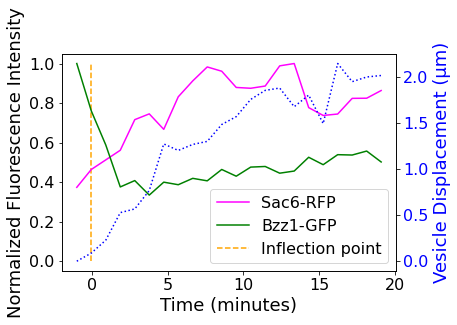

In [20]:
track = '4.4.3M1001_bs_bcexp_bead1_dc_trackmate.csv_track0'

ax1 = plt.subplot(1,1,1)
ax2 = ax1.twinx()
df = tracks_dict[track].set_index('FRAME')
time = df['POSITION_T']/60
inflection = findInflectionPoint(time, df['DISPLACEMENT'])
time_aligned = time - inflection
ax1.plot(time_aligned, df['MEAN_INTENSITY01']/np.max(df['MEAN_INTENSITY01']), 
         color='magenta', label = 'Sac6-RFP')
ax1.plot(time_aligned, df['MEAN_INTENSITY02']/np.max(df['MEAN_INTENSITY02']), 
         color='green', label = 'Bzz1-GFP')
ax2.plot(time_aligned, df['DISPLACEMENT'], linestyle=':',
         color = 'blue', label = 'Displacement')
plt.tick_params(labelcolor='blue')
plt.ylabel('Vesicle Displacement (µm)', color='blue')
ax1.vlines(time[inflection]-inflection, 0, 1, linestyle='dashed', color = 'orange', label = 'Inflection point')
ax1.set(xlabel = 'Time (minutes)', ylabel = 'Normalized Fluorescence Intensity')
#ax2.set(ylabel = 'Vesicle Displacement (µm)', color='blue')
ax1.legend(loc='lower right')

plt.savefig('figures/5b_track.svg')
plt.savefig('figures/5b_track.png')

## Align time to inflection point, take mean by aligned time

In [28]:
for track in tracks_dict:
    df = tracks_dict[track].set_index("FRAME")
    time = df['POSITION_T']
    displacement = df['DISPLACEMENT']
    inflection = findInflectionPoint(time, displacement)
    time_aligned = (time - time[inflection])//60 #round down to 1 minute
    print(min(time_aligned), max(time_aligned))
    df['time_aligned'] = time_aligned
    displacement_aligned = displacement - displacement[inflection]
    df['displacement_aligned']= displacement_aligned
    rfp_norm = df['MEAN_INTENSITY01']/np.max(df['MEAN_INTENSITY01'])
    df['rfp_norm'] = rfp_norm
    gfp_norm = df['MEAN_INTENSITY02']/np.max(df['MEAN_INTENSITY02'])
    df['gfp_norm'] = gfp_norm
    tracks_dict[track] = df

-7.0 8.0
-6.0 15.0
-5.0 6.0
-40.0 9.0
-42.0 7.0
-41.0 8.0
-37.0 12.0
-42.0 8.0
-9.0 20.0
-3.0 27.0
-1.0 19.0
-44.0 5.0
-36.0 13.0
-8.0 21.0
-5.0 25.0
-10.0 19.0
-10.0 19.0
-11.0 18.0
-11.0 18.0
-14.0 7.0
-5.0 25.0
-3.0 27.0
-7.0 14.0
-11.0 10.0
-5.0 15.0
-6.0 14.0
-2.0 18.0
-1.0 19.0
-11.0 10.0
-12.0 8.0
-10.0 10.0
-12.0 9.0
-6.0 61.0
-4.0 26.0
-5.0 25.0
-9.0 20.0
-7.0 23.0


In [29]:
all_tracks = pd.concat(tracks_dict, sort=False)
all_tracks_combined = all_tracks.groupby('time_aligned').agg(['mean','std','count'])

## Plot all aligned traces on same graph

(-30.0, 20.0)

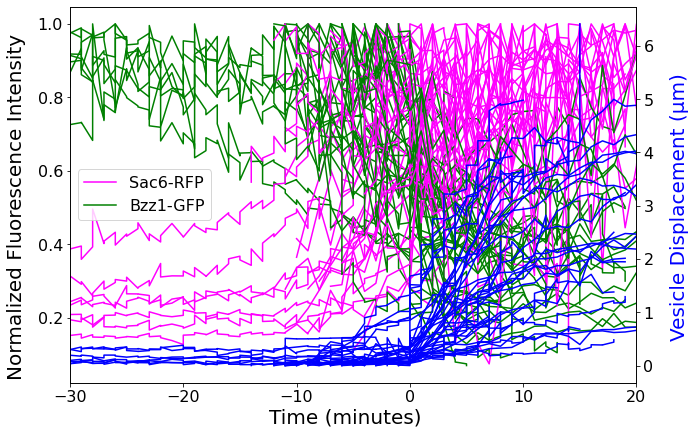

In [23]:
fig, ax = plt.subplots(nrows=height, ncols=width, sharex=True, sharey=True, figsize=(10,6))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
fig.text(0.5, 0, 'Time (minutes)', ha='center', size=20)
fig.text(0.03, 0.5, 'Normalized Fluorescence Intensity', va='center', rotation='vertical', size=20)
fig.text(0.95, 0.5, 'Vesicle Displacement (µm)', va='center', rotation='vertical', size=20, color='blue')

ax1 = plt.subplot(111) #height, width
ax2 = ax1.twinx()

plot_no = 0

for track in tracks_dict:
    plot_no += 1
    df = tracks_dict[track]
    time = df['time_aligned']
    ax1.plot(time, df['MEAN_INTENSITY01']/np.max(df['MEAN_INTENSITY01']), 
             color='magenta', label = 'Sac6-RFP')
    ax1.plot(time, df['MEAN_INTENSITY02']/np.max(df['MEAN_INTENSITY02']), 
             color='green', label = 'Bzz1-GFP')
    ax2.plot(time, df['DISPLACEMENT'], color = 'blue', label = 'Displacement')
#    ax1.vlines(time[inflection], 0, 1, color = 'orange', label = 'Inflection point')
    if plot_no == 1:
            ax1.legend()

plt.tight_layout(pad = 1, rect = (0.05, 0.005, 0.95, 1))

plt.xlim(left= -30, right = 20)

#plt.savefig(working_dir+'figures/'+pref+'_norm_tracks_overlay.png')

## Figure 5c: Plot mean aligned fluorescence and displacement

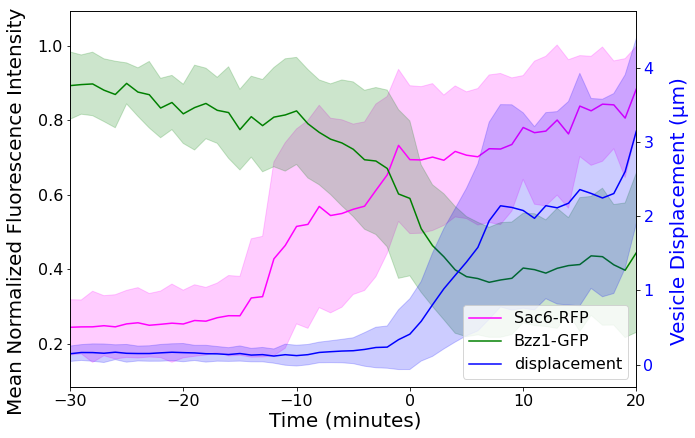

In [24]:
time_aligned = all_tracks_combined.index
displacement = all_tracks_combined['DISPLACEMENT']
displacement_aligned = all_tracks_combined['displacement_aligned']
rfp = all_tracks_combined['rfp_norm']
gfp = all_tracks_combined['gfp_norm']

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(10,6))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
fig.text(0.5, 0, 'Time (minutes)', ha='center', size=20)
fig.text(0.03, 0.5, 'Mean Normalized Fluorescence Intensity', va='center', rotation='vertical', size=20)
fig.text(0.95, 0.5, 'Vesicle Displacement (µm)', va='center', rotation='vertical', size=20, color='blue')

ax1 = plt.subplot(111)
ax2 = ax1.twinx()
ax1.plot(time_aligned,rfp['mean'], 
         color='magenta', label = 'Sac6-RFP')
ax1.fill_between(time_aligned,rfp['mean'] - rfp['std'], 
                 rfp['mean'] + rfp['std'], color='magenta', alpha=0.2)

ax1.plot(time_aligned,gfp['mean'], 
         color='green', label = 'Bzz1-GFP')
ax1.fill_between(time_aligned,gfp['mean'] - gfp['std'], 
                 gfp['mean'] + gfp['std'], color='green', alpha=0.2)

ax2.plot(time_aligned,displacement['mean'], color = 'blue', label='displacement')
ax2.fill_between(time_aligned,displacement['mean'] - displacement['std'], 
                 displacement['mean'] + displacement['std'], color='blue', alpha=0.2)
plt.tick_params(labelcolor='blue')

fig.legend(loc='lower right', bbox_to_anchor=(1,0), bbox_transform=ax1.transAxes)

#plt.plot(time_aligned,displacement_aligned, color = 'blue', label='aligned displacement')
#plt.fill_between(time_aligned,displacement_aligned - error['displacement_aligned'], 
#                 displacement_aligned + error['displacement_aligned'], color='blue', alpha=0.2)
plt.xlim(left= -30, right = 20)

plt.tight_layout(pad = 1, rect = (0.05, 0.005, 0.95, 1))

plt.savefig('figures/5c_mean_tracks.svg')
plt.savefig('figures/5c_mean_tracks.png')

# All panels for figure 5

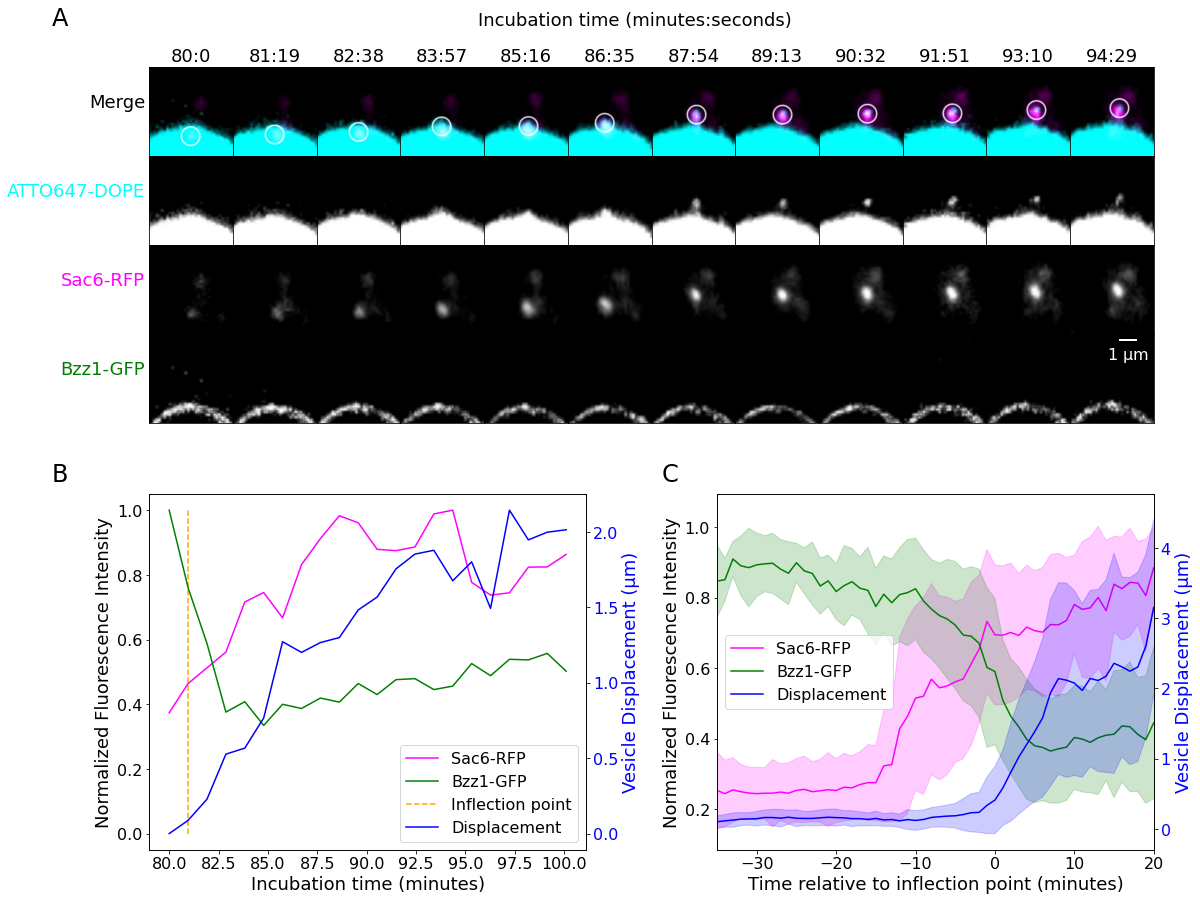

In [39]:
# WORK IN PROGRESS!

all_frames = raw.metadata['frames']
micron_per_px = raw.metadata['pixel_microns']
s_per_frame = vis_params.loc['Confocal 561 2']['s_per_frame']
frames = all_frames[0:12]
count = 0
width = 1.5*len(frames)
height = 0.8*width
channels = ['Merge','Confocal 638','Confocal 561 2','Confocal 488']

track = '4.4.3M1001_bs_bcexp_bead1_dc_trackmate.csv_track0'

fig5 = plt.figure(figsize=(width, height), constrained_layout=False)
fig5.text(0.05,0.92,'A', fontsize=BIGGER_SIZE)
fig5.text(0.05,0.48,'B', fontsize=BIGGER_SIZE)
fig5.text(0.52,0.48,'C', fontsize=BIGGER_SIZE)

# gridspec inside gridspec
outer_grid = fig5.add_gridspec(2, 2, wspace=0.3, hspace=0.2)

# panel A
inner_grid = outer_grid[0:2].subgridspec(len(channels),len(frames),
                                         wspace=0.0, hspace=0.0)
fig5.text(0.5,0.92,'Incubation time (minutes:seconds)',fontsize=MEDIUM_SIZE,ha='center')
for channel in channels:
    for tp in frames:
        ax = fig5.add_subplot(inner_grid[count])
        count += 1
        ax.imshow(max_projections[channel][tp,50:400,580:910])
        if channel == channels[0]:
            minutes = int(s_per_frame*tp//60)
            seconds = int(np.round((s_per_frame*tp/60-minutes)*60))
            plt.title(str(80+minutes)+':'+str(seconds))
        if tp == frames[0]:
            plt.ylabel(vis_params.loc[channel]['label'],
                       rotation=0,color=vis_params.loc[channel]['color'],
                       ha='right',)
        if count == len(frames)*len(channels):
            scalebar = ScaleBar(micron_per_px/10, 'um', box_alpha=0, color='w', 
                                length_fraction=0.4, height_fraction=0.02)
            plt.gca().add_artist(scalebar)
        ax.set_xticks([])
        ax.set_yticks([])
        fig5.add_subplot(ax)
        
# panel B
ax1 = fig5.add_subplot(outer_grid[2])
ax2 = ax1.twinx()
df = tracks_dict[track]
time = df['POSITION_T']/60
inflection = findInflectionPoint(time, df['DISPLACEMENT'])
time_aligned = time - inflection

incubation_time = time+80

ax1.plot(incubation_time, df['MEAN_INTENSITY01']/np.max(df['MEAN_INTENSITY01']), 
         color='magenta', label = 'Sac6-RFP')
ax1.plot(incubation_time, df['MEAN_INTENSITY02']/np.max(df['MEAN_INTENSITY02']), 
         color='green', label = 'Bzz1-GFP')
ax2.plot(incubation_time, df['DISPLACEMENT'],
         color = 'blue', label = 'Displacement')
plt.tick_params(labelcolor='blue')
plt.ylabel('Vesicle Displacement (µm)', color='blue')
ax1.vlines(incubation_time[inflection], 0, 1, linestyle='dashed', color = 'orange', label = 'Inflection point')
ax1.set(xlabel = 'Incubation time (minutes)', ylabel = 'Normalized Fluorescence Intensity')
#ax1.legend(loc='lower right')
fig5.legend(loc='lower right', bbox_to_anchor=(1,0), bbox_transform=ax1.transAxes)

# panel C
ax1 = fig5.add_subplot(outer_grid[3])
ax2 = ax1.twinx()

time_aligned = all_tracks_combined.index
displacement = all_tracks_combined['DISPLACEMENT']
displacement_aligned = all_tracks_combined['displacement_aligned']
rfp = all_tracks_combined['rfp_norm']
gfp = all_tracks_combined['gfp_norm']


ax1.plot(time_aligned,rfp['mean'], 
         color='magenta', label = 'Sac6-RFP')
ax1.fill_between(time_aligned,rfp['mean'] - rfp['std'], 
                 rfp['mean'] + rfp['std'], color='magenta', alpha=0.2)

ax1.plot(time_aligned,gfp['mean'], 
         color='green', label = 'Bzz1-GFP')
ax1.fill_between(time_aligned,gfp['mean'] - gfp['std'], 
                 gfp['mean'] + gfp['std'], color='green', alpha=0.2)

ax2.plot(time_aligned,displacement['mean'], color = 'blue', label='Displacement')
ax1.plot(np.nan, color = 'blue', label='Displacement')
ax2.fill_between(time_aligned,displacement['mean'] - displacement['std'], 
                 displacement['mean'] + displacement['std'], color='blue', alpha=0.2)
plt.tick_params(labelcolor='blue')
plt.ylabel('Vesicle Displacement (µm)', color='blue')
ax1.set(xlabel = 'Time relative to inflection point (minutes)', ylabel = 'Normalized Fluorescence Intensity')
ax1.legend(loc='center left')
#fig5.legend(loc='lower right', bbox_to_anchor=(1,0), bbox_transform=ax1.transAxes)

plt.xlim(left= -35, right = 20)

plt.savefig('figures/fig5_abc.png')

# Supplemental figures for fig. 5

## Figure 5 supplement 1

### Set paths to data

In [6]:
crop_tiff = 'data/4.4.4M1001_bs_bcexp_bead2_dc_bchist.tif'
raw_nd2 = 'data/4.4.4M1001.nd2'
track_csv = 'tracks/4.4.4M1001_bs_bcexp_bead2_dc_trackmate.csv'

### Read processed single bead crop

In [7]:
crop = io.imread(crop_tiff)
crop.shape

(97, 23, 77, 79, 3)

### Read raw data corresponding to processed stack

In [8]:
raw = ND2Reader(raw_nd2)
raw.bundle_axes = 'czyx'
raw

<FramesSequenceND>
Axes: 5
Axis 'x' size: 512
Axis 'y' size: 512
Axis 'c' size: 3
Axis 't' size: 97
Axis 'z' size: 21
Pixel Datatype: <class 'numpy.float64'>

### Read metadata from raw data

In [10]:
raw_metadata = nd2_metadata(raw)

In [11]:
channel_names = {'sac6':'Confocal 561 2',
                'bzz1':'Confocal 488',
                'dope':'Confocal 638'}
contrast = {'sac6':(345,1307),
            'bzz1':(180,490),
            'dope':(1160,2230)}
colors = {'sac6':'magenta',
        'bzz1':'green',
        'dope':'cyan'}
#labels = {'sac6':'Sac6-RFP',
#        'bzz1':'Bzz1-GFP',
#        'dope':'ATTO647-DOPE',
#         'merge':'Merge'}
labels = {'sac6':'Sac6-RFP',
        'bzz1':'Bzz1-GFP',
        'dope':'ATTO647-DOPE'}

vis_params = pd.DataFrame({'channel':channel_names,
             'contrast':contrast,
             'color':colors,
             'label':labels}).set_index('channel')
channel_order = {'stack_index':{}}
for i, channel in enumerate(raw_metadata['channel']):
    channel_order['stack_index'][channel] = i

vis_params = pd.concat([vis_params,pd.DataFrame(channel_order),
                       pd.DataFrame(raw_metadata).set_index('channel')],axis=1)

# hack to add merge visualization
vpm = vis_params.loc[vis_params.index[0]].copy()
vpm['label'] = 'Merge'
vpm['color'] = 'black'
vis_params.loc['Merge'] = vpm

#vis_params.loc['Merge'] = vis_params.loc[vis_params.index[0]].copy()
#vis_params.loc['Merge']['color'] = 'black'
#vis_params.loc['Merge']['label'] = 'Merge'
vis_params

contrast    color         label  stack_index  num_frames  \
Confocal 561 2   (345, 1307)  magenta      Sac6-RFP            0          97   
Confocal 488      (180, 490)    green      Bzz1-GFP            1          97   
Confocal 638    (1160, 2230)     cyan  ATTO647-DOPE            2          97   
Merge            (345, 1307)    black         Merge            0          97   

                s_per_frame      s_total  micron_per_px    min_z   max_z  \
Confocal 561 2    30.761141  2967.991596       0.140467  2044.65  2054.7   
Confocal 488      30.761141  2967.991596       0.140467  2044.65  2054.7   
Confocal 638      30.761141  2967.991596       0.140467  2044.65  2054.7   
Merge             30.761141  2967.991596       0.140467  2044.65  2054.7   

                z_range  z_slices  z_spacing  trackmate_z_ratio  \
Confocal 561 2    10.05        21   0.478571           0.957143   
Confocal 488      10.05        21   0.478571           0.957143   
Confocal 638      10.05        21   0.478571           0.957143   
Merge             10.05        21   0.478571           0.957143   

                trackmate_xy_ratio  
Confocal 561 2            0.999763  
Confocal 488              0.999763  
Confocal 638              0.999763  
Merge                     0.999763

### Read vesicle tracking data

In [22]:
trackmate_xy_ratio = vis_params['trackmate_xy_ratio'][0]
trackmate_z_ratio = vis_params['trackmate_z_ratio'][0]
micron_per_px = vis_params['micron_per_px'][0]
px_per_micron = 1/micron_per_px

track_df = pd.read_csv(track_csv)
frames = track_df['FRAME']
x = track_df['POSITION_X']*trackmate_xy_ratio*px_per_micron
y = track_df['POSITION_Y']*trackmate_xy_ratio*px_per_micron
z = track_df['POSITION_Z']*trackmate_z_ratio*px_per_micron
spots = np.transpose(np.array([frames,z,y,x]))
traj = np.transpose(np.array([z,y,x]))

### Make movies/montages

#### full time lapse

##### write movie script

In [19]:
tl_frames = crop.shape[0]-1
with open("movies/s5a_movie_script.txt", "w") as text_file:
    print('From frame 0 to frame 0\n'
    '-rotate by 30 degrees around (1,0,0)\n'
    f'From frame 0 to frame {tl_frames}\n'
    f'-shift time by {tl_frames}', file=text_file)

#### Narrower z-section time lapse

##### Record movies in napari

###### merge of sac6, bzz1, and lipid

/opt/miniconda3/envs/image_analysis/lib/python3.7/site-packages/vispy/visuals/tube.py:134: RuntimeWarning: invalid value encountered in true_divide
  tangents /= mags[:, np.newaxis]


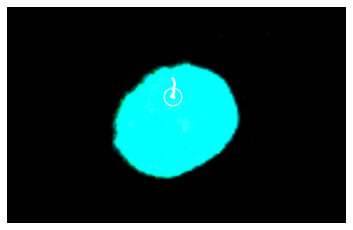

/opt/miniconda3/envs/image_analysis/lib/python3.7/site-packages/vispy/visuals/tube.py:134: RuntimeWarning: invalid value encountered in true_divide
  tangents /= mags[:, np.newaxis]


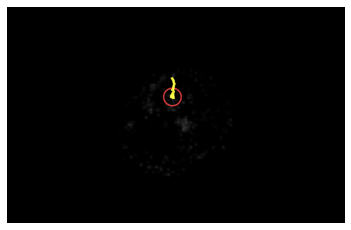

/opt/miniconda3/envs/image_analysis/lib/python3.7/site-packages/vispy/visuals/tube.py:134: RuntimeWarning: invalid value encountered in true_divide
  tangents /= mags[:, np.newaxis]


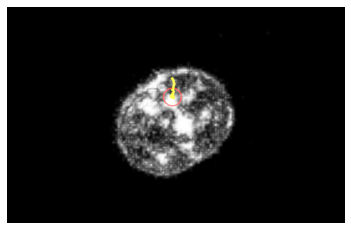

/opt/miniconda3/envs/image_analysis/lib/python3.7/site-packages/vispy/visuals/tube.py:134: RuntimeWarning: invalid value encountered in true_divide
  tangents /= mags[:, np.newaxis]


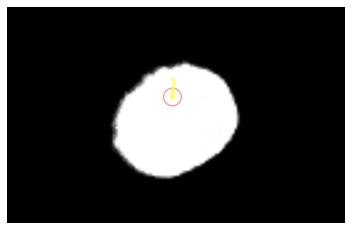

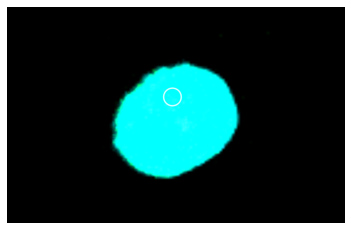

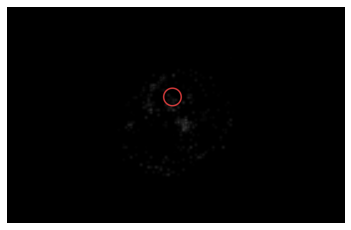

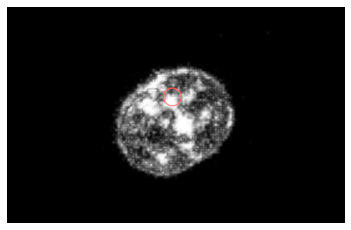

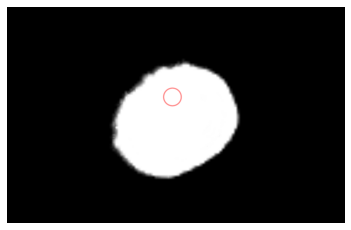

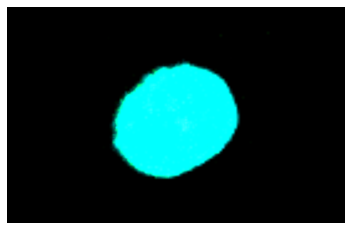

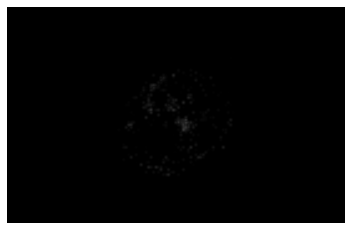

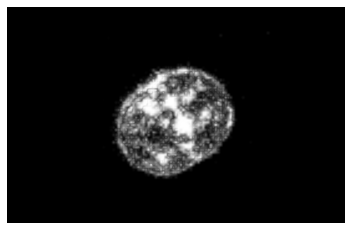

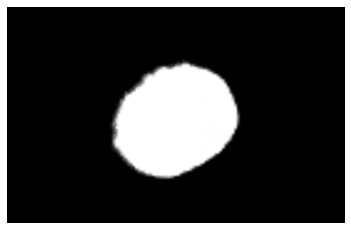

In [19]:
movie_3d(stack=crop, channels_list=['Confocal 561 2', 'Confocal 488', 'Confocal 638'],
         vis_params=vis_params,
         points=spots, traj=traj, z_low=4, z_high=19,
        script='movies/s5a_movie_script.txt', movie_name='s5a_spots_traj_movie')

movie_3d(stack=crop, channels_list=['Confocal 561 2', 'Confocal 488', 'Confocal 638'],
         vis_params=vis_params,
         points=spots, z_low=4, z_high=19,
        script='movies/s5a_movie_script.txt', movie_name='s5a_spots_movie')

movie_3d(stack=crop, channels_list=['Confocal 561 2', 'Confocal 488', 'Confocal 638'],
         vis_params=vis_params,
         z_low=4, z_high=19,
        script='movies/s5a_movie_script.txt', movie_name='s5a_movie')

###### sac6, bzz1, and lipid with 3D rotation

In [21]:
tl_frames = crop.shape[0]-1
tl_delay = tl_frames*3
rotation_frames = 50
with open("movies/s5a_rotation_movie_script.txt", "w") as text_file:
    print(
'From frame 0 to frame 0\n'
'-rotate by 30 degrees around (1,0,0)\n'
f'From frame 0 to frame {rotation_frames} rotate by 360 degrees around (0,0,1)\n'
f'From frame {rotation_frames} to frame {rotation_frames+tl_delay} shift time by {tl_frames}\n'
f'From frame {rotation_frames+tl_delay} to frame {rotation_frames+tl_delay*2} shift time by -{tl_frames}\n'
f'From frame {rotation_frames+tl_delay*2} to frame {rotation_frames*2+tl_delay*2} rotate by 360 degrees around (0,0,1)\n'
f'From frame {rotation_frames*2+tl_delay*2} to frame {rotation_frames*2+tl_delay*3} shift time by {tl_frames}', 
        file=text_file)

##### Read movies

In [20]:
max_projections = {'Merge':skvideo.io.vread('movies/s5a_spots_movie_merge.mp4'),
                  'Confocal 561 2':skvideo.io.vread('movies/s5a_movie_Sac6-RFP.mp4'),
                  'Confocal 488':skvideo.io.vread('movies/s5a_movie_Bzz1-GFP.mp4'),
                  'Confocal 638':skvideo.io.vread('movies/s5a_movie_ATTO647-DOPE.mp4')}
max_projections['Merge'].shape

(97, 960, 1500, 3)

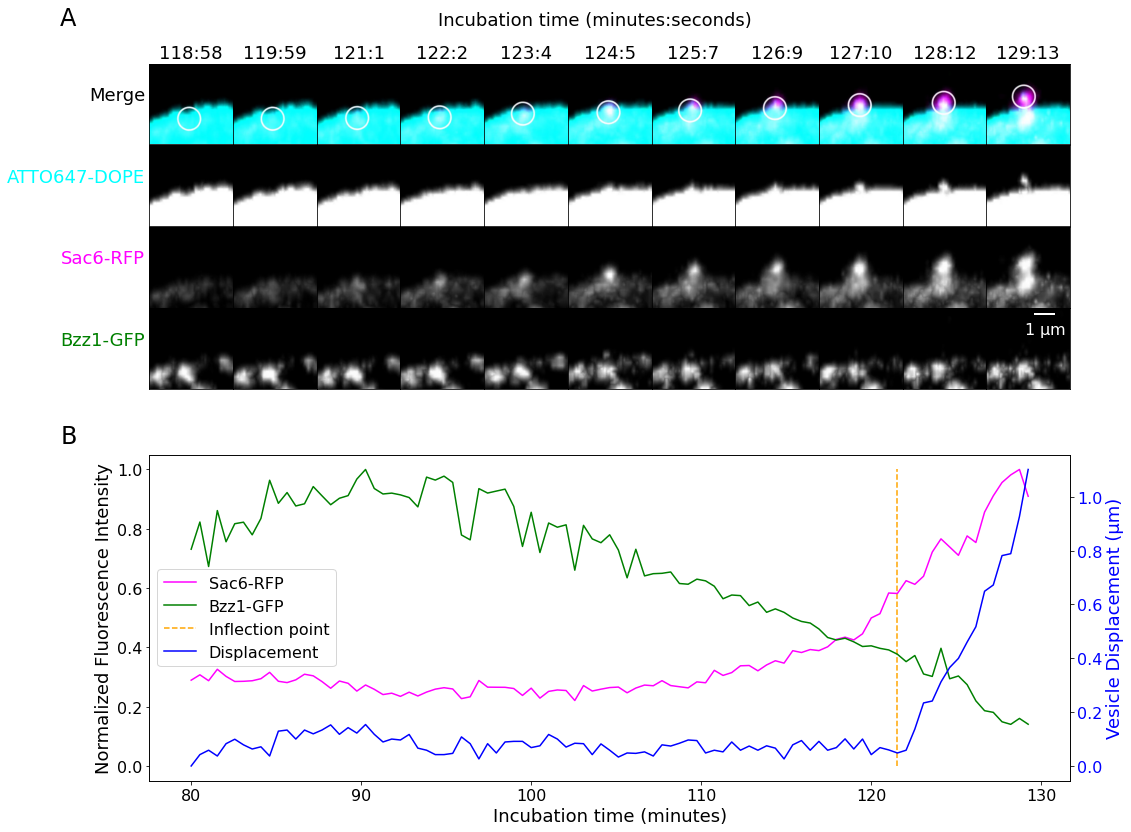

In [30]:
all_frames = raw.metadata['frames']
s_per_frame = vis_params.loc['Confocal 561 2']['s_per_frame']
frames = all_frames[-21::2]
count = 0
width = 1.5*len(frames)
height = 0.8*width
channels = ['Merge','Confocal 638','Confocal 561 2','Confocal 488']

track = '4.4.4M1001_bs_bcexp_bead2_dc_trackmate.csv_track0'

fig5 = plt.figure(figsize=(width, height), constrained_layout=False)
fig5.text(0.05,0.92,'A', fontsize=BIGGER_SIZE)
fig5.text(0.05,0.48,'B', fontsize=BIGGER_SIZE)
#fig5.text(0.52,0.48,'C', fontsize=BIGGER_SIZE)

# gridspec inside gridspec
outer_grid = fig5.add_gridspec(2, 2, wspace=0.3, hspace=0.2)

# panel A
inner_grid = outer_grid[0:2].subgridspec(len(channels),len(frames),
                                         wspace=0.0, hspace=0.0)
fig5.text(0.5,0.92,'Incubation time (minutes:seconds)',fontsize=MEDIUM_SIZE,ha='center')
for channel in channels:
    for tp in frames:
        ax = fig5.add_subplot(inner_grid[count])
        count += 1
        ax.imshow(max_projections[channel][tp,100:380,600:890])
        if channel == channels[0]:
            minutes = int(s_per_frame*tp//60)
            seconds = int(np.round((s_per_frame*tp/60-minutes)*60))
            plt.title(str(80+minutes)+':'+str(seconds))
        if tp == frames[0]:
            plt.ylabel(vis_params.loc[channel]['label'],
                       rotation=0,color=vis_params.loc[channel]['color'],
                       ha='right',)
        if count == len(frames)*len(channels):
            scalebar = ScaleBar(micron_per_px/10, 'um', box_alpha=0, color='w', 
                                length_fraction=0.4, height_fraction=0.02)
            plt.gca().add_artist(scalebar)
        ax.set_xticks([])
        ax.set_yticks([])
        fig5.add_subplot(ax)
        
# panel B
ax1 = fig5.add_subplot(outer_grid[2:4])
ax2 = ax1.twinx()
df = tracks_dict[track]
time = df['POSITION_T']/60
inflection = findInflectionPoint(time, df['DISPLACEMENT'])
time_aligned = time - inflection

incubation_time = time+80

ax1.plot(incubation_time, df['MEAN_INTENSITY01']/np.max(df['MEAN_INTENSITY01']), 
         color='magenta', label = 'Sac6-RFP')
ax1.plot(incubation_time, df['MEAN_INTENSITY02']/np.max(df['MEAN_INTENSITY02']), 
         color='green', label = 'Bzz1-GFP')
ax2.plot(incubation_time, df['DISPLACEMENT'],
         color = 'blue', label = 'Displacement')
plt.tick_params(labelcolor='blue')
plt.ylabel('Vesicle Displacement (µm)', color='blue')
ax1.vlines(incubation_time[inflection], 0, 1, linestyle='dashed', color = 'orange', label = 'Inflection point')
ax1.set(xlabel = 'Incubation time (minutes)', ylabel = 'Normalized Fluorescence Intensity')
#plt.xlim(left=90)
#ax1.legend(loc='lower right')
fig5.legend(loc='center left', bbox_to_anchor=(0,0.5), bbox_transform=ax1.transAxes)

plt.savefig('figures/figs5ab.png')

## Figure 5 supplement 2

### Set paths to data

In [29]:
crop_tiff = 'data/4.4.4M2003_bs_bcexp_bead7_dc.tif'
raw_nd2 = 'data/4.4.4M2003.nd2'
track_csv = 'tracks/4.4.4M2003_bs_bcexp_bead7_dc_trackmate.csv'
track = '4.4.4M2003_bs_bcexp_bead7_dc_trackmate.csv_track3'

### Read processed single bead crop

In [30]:
crop = io.imread(crop_tiff)
crop.shape

(29, 60, 75, 82, 3)

### Read raw data corresponding to processed stack

In [31]:
raw = ND2Reader(raw_nd2)
raw.bundle_axes = 'czyx'
raw

<FramesSequenceND>
Axes: 5
Axis 'x' size: 512
Axis 'y' size: 512
Axis 'c' size: 3
Axis 't' size: 29
Axis 'z' size: 46
Pixel Datatype: <class 'numpy.float64'>

### Read metadata from raw data

In [32]:
raw_metadata = nd2_metadata(raw, trackmate_z_spacing=0.2)

In [33]:
channel_names = {'sac6':'Confocal 561 2',
                'bzz1':'Confocal 488',
                'dope':'Confocal 638'}
contrast = {'sac6':(240,1250),
            'bzz1':(145,560),
            'dope':(350,730)}
colors = {'sac6':'magenta',
        'bzz1':'green',
        'dope':'cyan'}
#labels = {'sac6':'Sac6-RFP',
#        'bzz1':'Bzz1-GFP',
#        'dope':'ATTO647-DOPE',
#         'merge':'Merge'}
labels = {'sac6':'Sac6-RFP',
        'bzz1':'Bzz1-GFP',
        'dope':'ATTO647-DOPE'}

vis_params = pd.DataFrame({'channel':channel_names,
             'contrast':contrast,
             'color':colors,
             'label':labels}).set_index('channel')
channel_order = {'stack_index':{}}
for i, channel in enumerate(raw_metadata['channel']):
    channel_order['stack_index'][channel] = i

vis_params = pd.concat([vis_params,pd.DataFrame(channel_order),
                       pd.DataFrame(raw_metadata).set_index('channel')],axis=1)

# hack to add merge visualization
vpm = vis_params.loc[vis_params.index[0]].copy()
vpm['label'] = 'Merge'
vpm['color'] = 'black'
vis_params.loc['Merge'] = vpm

#vis_params.loc['Merge'] = vis_params.loc[vis_params.index[0]].copy()
#vis_params.loc['Merge']['color'] = 'black'
#vis_params.loc['Merge']['label'] = 'Merge'
vis_params

contrast    color         label  stack_index  num_frames  \
Confocal 561 2  (240, 1250)  magenta      Sac6-RFP            0          29   
Confocal 488     (145, 560)    green      Bzz1-GFP            1          29   
Confocal 638     (350, 730)     cyan  ATTO647-DOPE            2          29   
Merge           (240, 1250)    black         Merge            0          29   

                s_per_frame      s_total  micron_per_px     min_z   max_z  \
Confocal 561 2    62.764401  1785.454631       0.140467  2062.425  2071.3   
Confocal 488      62.764401  1785.454631       0.140467  2062.425  2071.3   
Confocal 638      62.764401  1785.454631       0.140467  2062.425  2071.3   
Merge             62.764401  1785.454631       0.140467  2062.425  2071.3   

                z_range  z_slices  z_spacing  trackmate_z_ratio  \
Confocal 561 2    8.875        46   0.192935           0.964674   
Confocal 488      8.875        46   0.192935           0.964674   
Confocal 638      8.875        46   0.192935           0.964674   
Merge             8.875        46   0.192935           0.964674   

                trackmate_xy_ratio  
Confocal 561 2            0.999763  
Confocal 488              0.999763  
Confocal 638              0.999763  
Merge                     0.999763

### Read vesicle tracking data

In [34]:
trackmate_xy_ratio = vis_params['trackmate_xy_ratio'][0]
trackmate_z_ratio = vis_params['trackmate_z_ratio'][0]
micron_per_px = vis_params['micron_per_px'][0]
px_per_micron = 1/micron_per_px

track_df = tracks_dict[track]
frames = track_df.index
x = track_df['POSITION_X']*trackmate_xy_ratio*px_per_micron
y = track_df['POSITION_Y']*trackmate_xy_ratio*px_per_micron
z = track_df['POSITION_Z']*trackmate_z_ratio*px_per_micron
spots = np.transpose(np.array([frames,z,y,x]))
traj = np.transpose(np.array([z,y,x]))

### Make movies/montages

#### full time lapse

##### write movie script

In [16]:
tl_frames = crop.shape[0]-1
with open("movies/s5b_movie_script.txt", "w") as text_file:
    print('From frame 0 to frame 0\n'
    '-rotate by 90 degrees around (0,1,0)\n'
    f'From frame 0 to frame {tl_frames}\n'
    f'-shift time by {tl_frames}', file=text_file)

#### Narrower z-section time lapse

##### Record movies in napari

###### merge of sac6, bzz1, and lipid

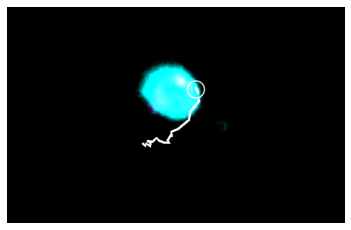

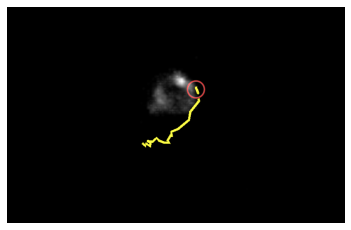

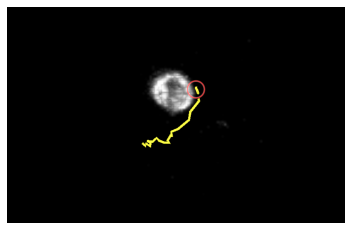

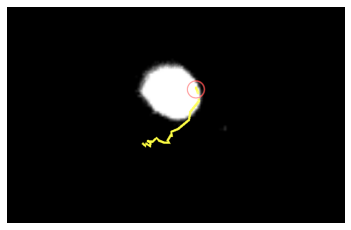

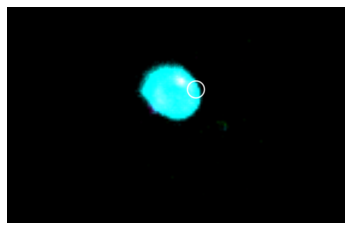

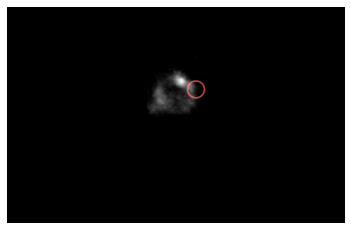

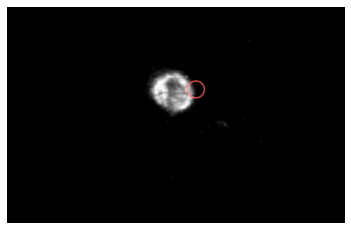

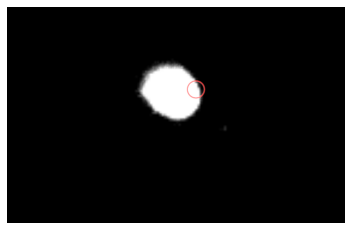

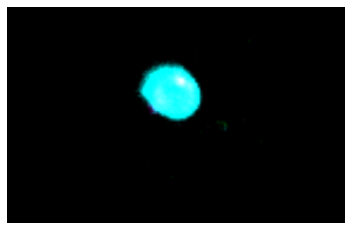

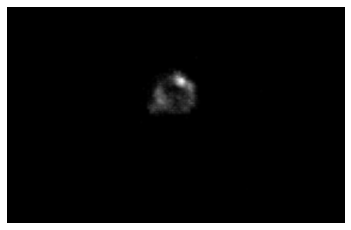

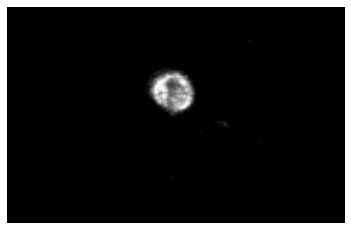

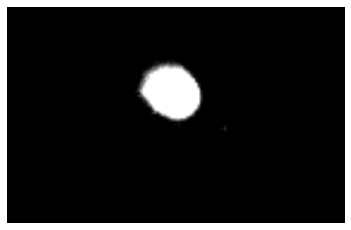

In [82]:
movie_3d(stack=crop, channels_list=['Confocal 561 2', 'Confocal 488', 'Confocal 638'],
         vis_params=vis_params,
         points=spots, traj=traj, z_low=27, z_high=45,
        script='movies/s5b_movie_script.txt', movie_name='s5b_spots_traj_movie')

movie_3d(stack=crop, channels_list=['Confocal 561 2', 'Confocal 488', 'Confocal 638'],
         vis_params=vis_params,
         points=spots, z_low=27, z_high=45,
        script='movies/s5b_movie_script.txt', movie_name='s5b_spots_movie')

movie_3d(stack=crop, channels_list=['Confocal 561 2', 'Confocal 488', 'Confocal 638'],
         vis_params=vis_params,
         z_low=27, z_high=45,
        script='movies/s5b_movie_script.txt', movie_name='s5b_movie')

immediately next:
- clean up full fig. 5 code to make it more portable
- make montage/quantification supp figure
- repeat for a couple more vesiculation events
- clean up previous code to use movie function

##### Read movies

In [35]:
max_projections = {'Merge':skvideo.io.vread('movies/s5b_spots_movie_merge.mp4'),
                  'Confocal 561 2':skvideo.io.vread('movies/s5b_movie_Sac6-RFP.mp4'),
                  'Confocal 488':skvideo.io.vread('movies/s5b_movie_Bzz1-GFP.mp4'),
                  'Confocal 638':skvideo.io.vread('movies/s5b_movie_ATTO647-DOPE.mp4')}
max_projections['Merge'].shape

(29, 960, 1500, 3)

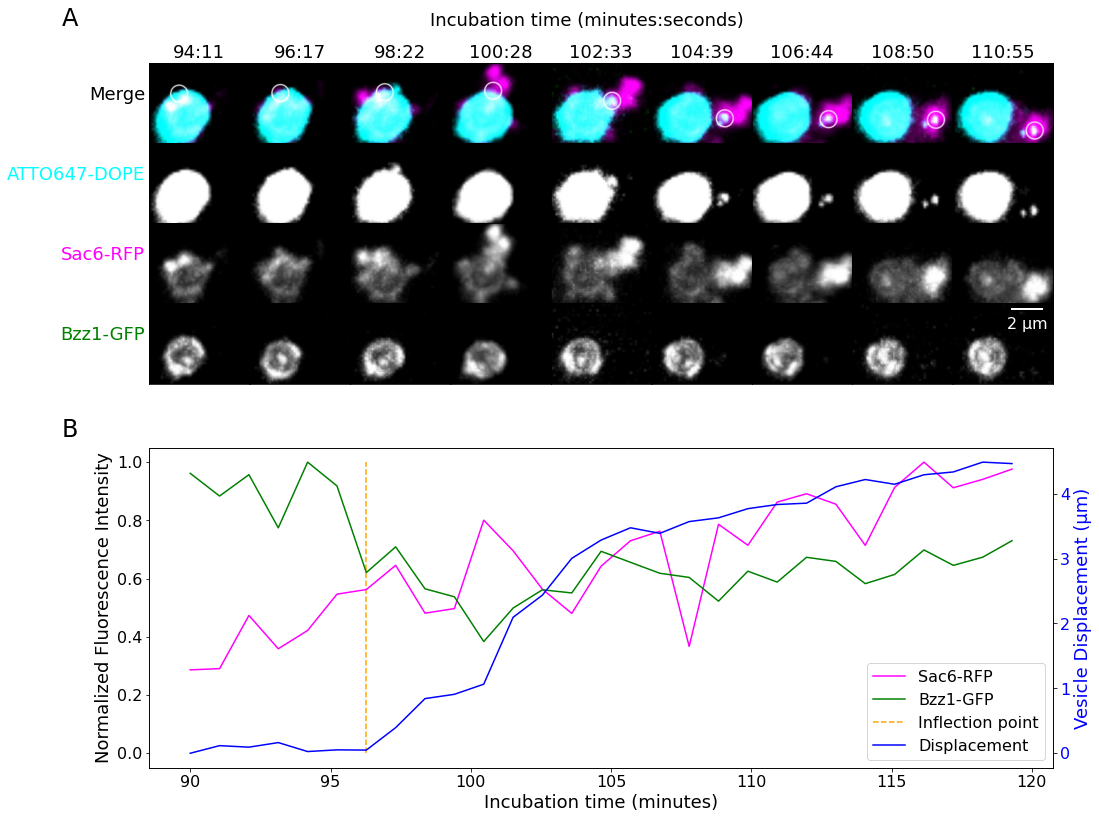

In [52]:
all_frames = raw.metadata['frames']
s_per_frame = vis_params.loc['Confocal 561 2']['s_per_frame']
frames = all_frames[4:-7:2]
count = 0
width = 1.8*len(frames)
height = 0.8*width
channels = ['Merge','Confocal 638','Confocal 561 2','Confocal 488']

fig5 = plt.figure(figsize=(width, height), constrained_layout=False)
fig5.text(0.05,0.92,'A', fontsize=BIGGER_SIZE)
fig5.text(0.05,0.48,'B', fontsize=BIGGER_SIZE)
#fig5.text(0.52,0.48,'C', fontsize=BIGGER_SIZE)

# gridspec inside gridspec
outer_grid = fig5.add_gridspec(2, 1, wspace=0.3, hspace=0.2)

# panel A
inner_grid = outer_grid[0].subgridspec(len(channels),len(frames),
                                         wspace=0.0, hspace=0.0)
fig5.text(0.5,0.92,'Incubation time (minutes:seconds)',fontsize=MEDIUM_SIZE,ha='center')
for channel in channels:
    for tp in frames:
        ax = fig5.add_subplot(inner_grid[count])
        count += 1
        ax.imshow(max_projections[channel][tp,250:-350,500:-550])
        if channel == channels[0]:
            minutes = int(s_per_frame*tp//60)
            seconds = int(np.round((s_per_frame*tp/60-minutes)*60))
            plt.title(str(90+minutes)+':'+str(seconds))
        if tp == frames[0]:
            plt.ylabel(vis_params.loc[channel]['label'],
                       rotation=0,color=vis_params.loc[channel]['color'],
                       ha='right',)
        if count == len(frames)*len(channels):
            scalebar = ScaleBar(micron_per_px/10, 'um', box_alpha=0, color='w', 
                                length_fraction=0.4, height_fraction=0.02)
            plt.gca().add_artist(scalebar)
        ax.set_xticks([])
        ax.set_yticks([])
        fig5.add_subplot(ax)
        
# panel B
ax1 = fig5.add_subplot(outer_grid[1])
ax2 = ax1.twinx()
df = tracks_dict[track].set_index('FRAME')
time = df['POSITION_T']/60
inflection = findInflectionPoint(time, df['DISPLACEMENT'])
time_aligned = time - inflection

incubation_time = time+90

ax1.plot(incubation_time, df['MEAN_INTENSITY01']/np.max(df['MEAN_INTENSITY01']), 
         color='magenta', label = 'Sac6-RFP')
ax1.plot(incubation_time, df['MEAN_INTENSITY02']/np.max(df['MEAN_INTENSITY02']), 
         color='green', label = 'Bzz1-GFP')
ax2.plot(incubation_time, df['DISPLACEMENT'],
         color = 'blue', label = 'Displacement')
plt.tick_params(labelcolor='blue')
plt.ylabel('Vesicle Displacement (µm)', color='blue')
ax1.vlines(incubation_time[inflection], 0, 1, linestyle='dashed', color = 'orange', label = 'Inflection point')
ax1.set(xlabel = 'Incubation time (minutes)', ylabel = 'Normalized Fluorescence Intensity')
#plt.xlim(left=90)
#ax1.legend(loc='lower right')
fig5.legend(loc='lower right', bbox_to_anchor=(1,0), bbox_transform=ax1.transAxes)

plt.savefig('figures/figs5b.png')

## Figure 5 supplement 3

### Set paths to data

In [74]:
crop_tiff = 'data/4.4.5M1002_bs_bcexp_bead1_dc.tif'
raw_nd2 = 'data/4.4.5M1002.nd2'
track = '4.4.5M1002_bs_bcexp_bead1_dc_trackmate.csv_track0'

### Read processed single bead crop

In [75]:
crop = io.imread(crop_tiff)
crop.shape

(52, 72, 99, 83, 3)

### Read raw data corresponding to processed stack

In [76]:
raw = ND2Reader(raw_nd2)
raw.bundle_axes = 'czyx'
raw

<FramesSequenceND>
Axes: 5
Axis 'x' size: 512
Axis 'y' size: 512
Axis 'c' size: 3
Axis 't' size: 52
Axis 'z' size: 58
Pixel Datatype: <class 'numpy.float64'>

### Read metadata from raw data

In [77]:
raw_metadata = nd2_metadata(raw, trackmate_z_spacing=0.2)

In [78]:
channel_names = {'sac6':'Confocal 561 2',
                'bzz1':'Confocal 488',
                'dope':'Confocal 638'}
contrast = {'sac6':(630,2200),
            'bzz1':(450,1230),
            'dope':(680,1180)}
colors = {'sac6':'magenta',
        'bzz1':'green',
        'dope':'cyan'}
#labels = {'sac6':'Sac6-RFP',
#        'bzz1':'Bzz1-GFP',
#        'dope':'ATTO647-DOPE',
#         'merge':'Merge'}
labels = {'sac6':'Sac6-RFP',
        'bzz1':'Bzz1-GFP',
        'dope':'ATTO647-DOPE'}

vis_params = pd.DataFrame({'channel':channel_names,
             'contrast':contrast,
             'color':colors,
             'label':labels}).set_index('channel')
channel_order = {'stack_index':{}}
for i, channel in enumerate(raw_metadata['channel']):
    channel_order['stack_index'][channel] = i

vis_params = pd.concat([vis_params,pd.DataFrame(channel_order),
                       pd.DataFrame(raw_metadata).set_index('channel')],axis=1)

# hack to add merge visualization
vpm = vis_params.loc[vis_params.index[0]].copy()
vpm['label'] = 'Merge'
vpm['color'] = 'black'
vis_params.loc['Merge'] = vpm

#vis_params.loc['Merge'] = vis_params.loc[vis_params.index[0]].copy()
#vis_params.loc['Merge']['color'] = 'black'
#vis_params.loc['Merge']['label'] = 'Merge'
vis_params

contrast    color         label  stack_index  num_frames  \
Confocal 561 2  (630, 2200)  magenta      Sac6-RFP            0          52   
Confocal 488    (450, 1230)    green      Bzz1-GFP            1          52   
Confocal 638    (680, 1180)     cyan  ATTO647-DOPE            2          52   
Merge           (630, 2200)    black         Merge            0          52   

                s_per_frame      s_total  micron_per_px   min_z     max_z  \
Confocal 561 2    78.974528  4065.334368       0.140467  2054.6  2066.075   
Confocal 488      78.974528  4065.334368       0.140467  2054.6  2066.075   
Confocal 638      78.974528  4065.334368       0.140467  2054.6  2066.075   
Merge             78.974528  4065.334368       0.140467  2054.6  2066.075   

                z_range  z_slices  z_spacing  trackmate_z_ratio  \
Confocal 561 2   11.475        58   0.197845           0.989224   
Confocal 488     11.475        58   0.197845           0.989224   
Confocal 638     11.475        58   0.197845           0.989224   
Merge            11.475        58   0.197845           0.989224   

                trackmate_xy_ratio  
Confocal 561 2            0.999763  
Confocal 488              0.999763  
Confocal 638              0.999763  
Merge                     0.999763

### Read vesicle tracking data

In [79]:
trackmate_xy_ratio = vis_params['trackmate_xy_ratio'][0]
trackmate_z_ratio = vis_params['trackmate_z_ratio'][0]
micron_per_px = vis_params['micron_per_px'][0]
px_per_micron = 1/micron_per_px

track_df = tracks_dict[track]
frames = track_df.index
x = track_df['POSITION_X']*trackmate_xy_ratio*px_per_micron
y = track_df['POSITION_Y']*trackmate_xy_ratio*px_per_micron
z = track_df['POSITION_Z']*trackmate_z_ratio*px_per_micron
spots = np.transpose(np.array([frames,z,y,x]))
traj = np.transpose(np.array([z,y,x]))

### Make movies/montages

#### full time lapse

##### write movie script

In [40]:
tl_frames = crop.shape[0]-1
with open("movies/s5c_movie_script.txt", "w") as text_file:
    print('From frame 0 to frame 0\n'
    '-rotate by 38 degrees around (0,1,0)\n'
    f'From frame 0 to frame {tl_frames}\n'
    f'-shift time by {tl_frames}', file=text_file)

#### Narrower z-section time lapse

##### Record movies in napari

###### merge of sac6, bzz1, and lipid

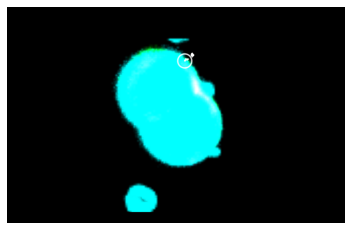

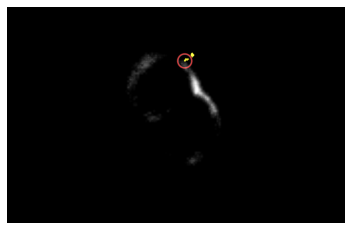

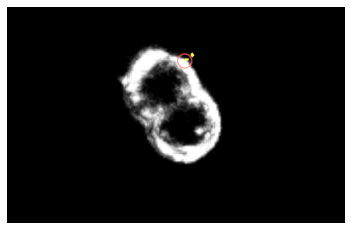

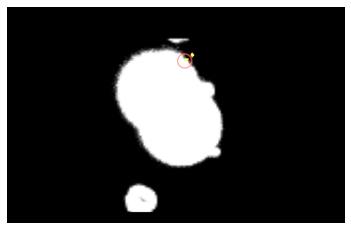

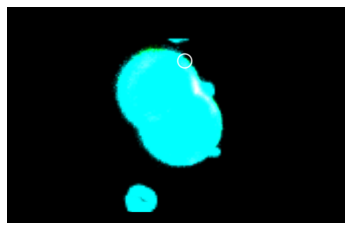

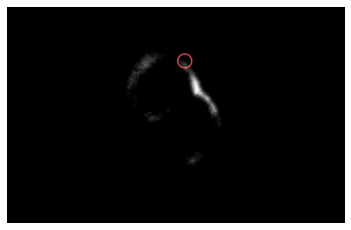

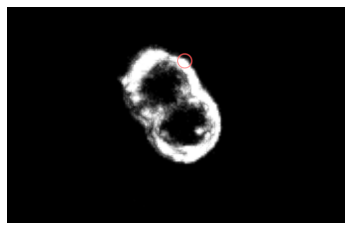

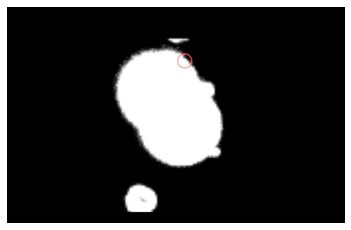

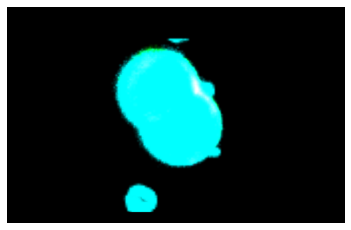

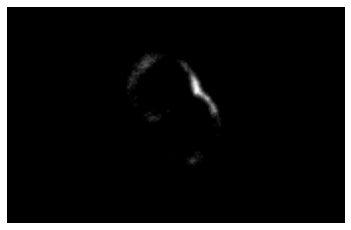

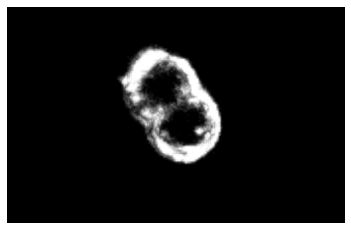

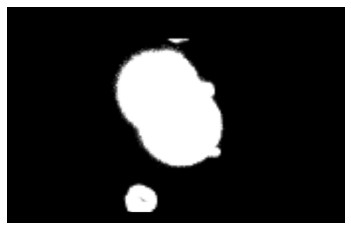

In [41]:
movie_3d(stack=crop, channels_list=['Confocal 561 2', 'Confocal 488', 'Confocal 638'],
         vis_params=vis_params,
         points=spots, traj=traj, z_low=18, z_high=40,
        script='movies/s5c_movie_script.txt', movie_name='s5c_spots_traj_movie')

movie_3d(stack=crop, channels_list=['Confocal 561 2', 'Confocal 488', 'Confocal 638'],
         vis_params=vis_params,
         points=spots, z_low=18, z_high=40,
        script='movies/s5c_movie_script.txt', movie_name='s5c_spots_movie')

movie_3d(stack=crop, channels_list=['Confocal 561 2', 'Confocal 488', 'Confocal 638'],
         vis_params=vis_params,
         z_low=18, z_high=40,
        script='movies/s5c_movie_script.txt', movie_name='s5c_movie')

##### Read movies

In [80]:
max_projections = {'Merge':skvideo.io.vread('movies/s5c_spots_movie_merge.mp4'),
                  'Confocal 561 2':skvideo.io.vread('movies/s5c_movie_Sac6-RFP.mp4'),
                  'Confocal 488':skvideo.io.vread('movies/s5c_movie_Bzz1-GFP.mp4'),
                  'Confocal 638':skvideo.io.vread('movies/s5c_movie_ATTO647-DOPE.mp4')}
max_projections['Merge'].shape

(52, 960, 1500, 3)

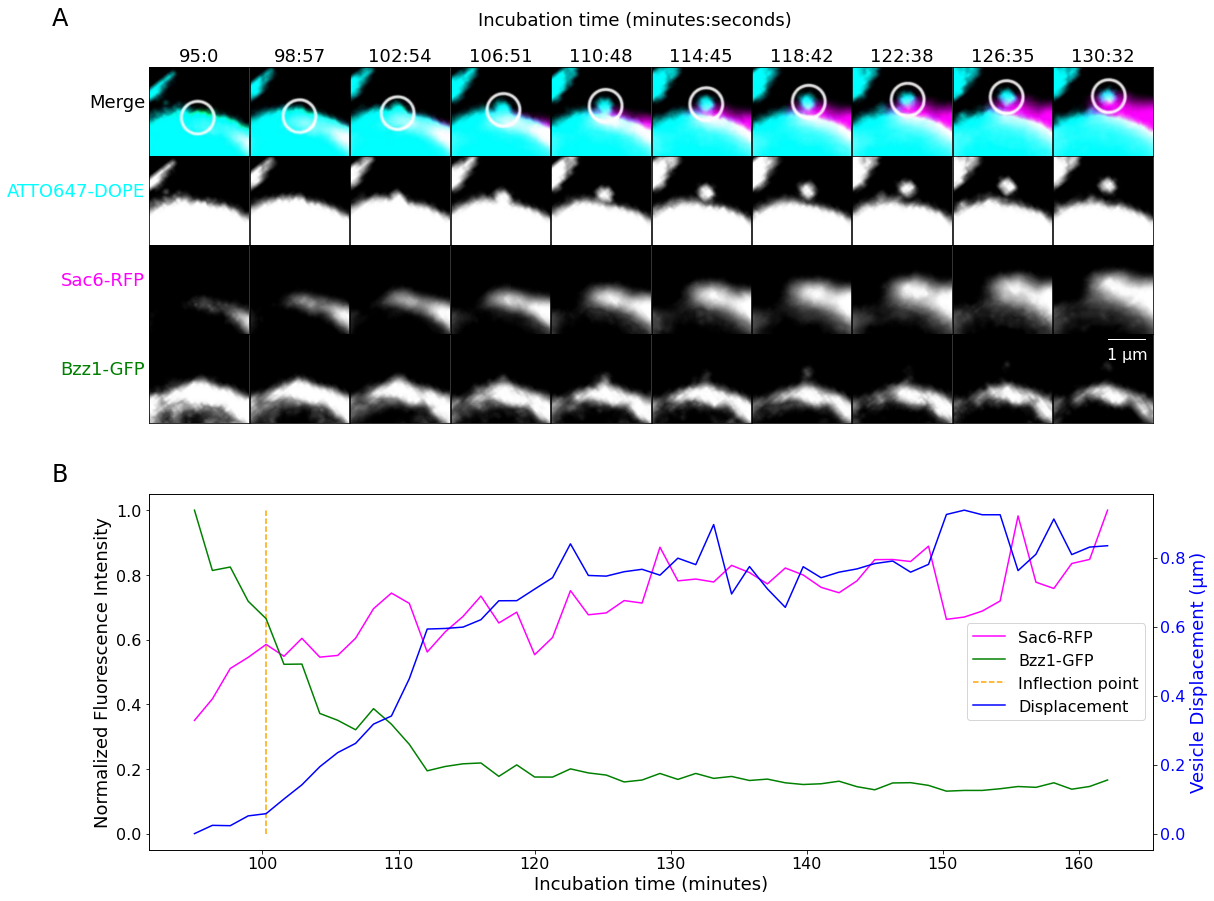

In [81]:
all_frames = raw.metadata['frames']
s_per_frame = vis_params.loc['Confocal 561 2']['s_per_frame']
frames = all_frames[:29:3]
count = 0
width = 1.8*len(frames)
height = 0.8*width
channels = ['Merge','Confocal 638','Confocal 561 2','Confocal 488']

fig5 = plt.figure(figsize=(width, height), constrained_layout=False)
fig5.text(0.05,0.92,'A', fontsize=BIGGER_SIZE)
fig5.text(0.05,0.48,'B', fontsize=BIGGER_SIZE)
#fig5.text(0.52,0.48,'C', fontsize=BIGGER_SIZE)

# gridspec inside gridspec
outer_grid = fig5.add_gridspec(2, 1, wspace=0.3, hspace=0.2)

# panel A
inner_grid = outer_grid[0].subgridspec(len(channels),len(frames),
                                         wspace=0.0, hspace=0.0)
fig5.text(0.5,0.92,'Incubation time (minutes:seconds)',fontsize=MEDIUM_SIZE,ha='center')
for channel in channels:
    for tp in frames:
        ax = fig5.add_subplot(inner_grid[count])
        count += 1
        ax.imshow(max_projections[channel][tp,170:-620,540:-770])
        if channel == channels[0]:
            minutes = int(s_per_frame*tp//60)
            seconds = int(np.round((s_per_frame*tp/60-minutes)*60))
            plt.title(str(95+minutes)+':'+str(seconds))
        if tp == frames[0]:
            plt.ylabel(vis_params.loc[channel]['label'],
                       rotation=0,color=vis_params.loc[channel]['color'],
                       ha='right',)
        if count == len(frames)*len(channels):
            scalebar = ScaleBar(micron_per_px/10, 'um', box_alpha=0, color='w', 
                                length_fraction=0.4, height_fraction=0.02)
            plt.gca().add_artist(scalebar)
        ax.set_xticks([])
        ax.set_yticks([])
        fig5.add_subplot(ax)
        
# panel B
ax1 = fig5.add_subplot(outer_grid[1])
ax2 = ax1.twinx()
df = tracks_dict[track].set_index('FRAME')
time = df['POSITION_T']/60
inflection = findInflectionPoint(time, df['DISPLACEMENT'])
time_aligned = time - inflection

incubation_time = time+95

ax1.plot(incubation_time, df['MEAN_INTENSITY01']/np.max(df['MEAN_INTENSITY01']), 
         color='magenta', label = 'Sac6-RFP')
ax1.plot(incubation_time, df['MEAN_INTENSITY02']/np.max(df['MEAN_INTENSITY02']), 
         color='green', label = 'Bzz1-GFP')
ax2.plot(incubation_time, df['DISPLACEMENT'],
         color = 'blue', label = 'Displacement')
plt.tick_params(labelcolor='blue')
plt.ylabel('Vesicle Displacement (µm)', color='blue')
ax1.vlines(incubation_time[inflection], 0, 1, linestyle='dashed', color = 'orange', label = 'Inflection point')
ax1.set(xlabel = 'Incubation time (minutes)', ylabel = 'Normalized Fluorescence Intensity')
#plt.xlim(left=90)
#ax1.legend(loc='lower right')
fig5.legend(loc='center right', bbox_to_anchor=(1,0.5), bbox_transform=ax1.transAxes)

plt.savefig('figures/figs5c.png')